99242067 - Sepehr Rezaee

## Import dependencies

In [ ]:
import os
import math
import torch
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

### A) Defining a model with parameters that can be changed and the necessary methods.

In [ ]:
class CurrentDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.data = dataframe  # initialize the dataset with a pandas dataframe

    def __len__(self):
        return len(self.data)  # return the length of the dataset

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data.loc[idx].values
        return torch.tensor(sample)

In [ ]:
class LIF(torch.nn.Module):
    """
    Leaky Integrate-and-Fire (LIF) neuron model implementation in PyTorch.
    """

    def __init__(self, R=0.01, tau=8, u_rest=-65, u_th=-50):
        """
        Constructor for the LIF class.

        :param R: Resistance of the neuron
        :param tau: Membrane time constant
        :param u_rest: Resting potential of the neuron
        :param u_th: Threshold potential of the neuron
        """
        super(LIF, self).__init__()
        self.R = R  # resistance of the neuron
        self.tau = tau  # membrane time constant
        self.u_rest = u_rest  # resting potential of the neuron
        self.u_th = u_th  # threshold potential of the neuron
        self.u = u_rest  # initialize the neuron's voltage to the resting potential
        self.time = 0.0  # initialize time to zero
        self.u_hist = torch.tensor([self.time, self.u])  # initialize a history of voltage values
        self.frequency = torch.tensor([0, 0])  # initialize a history of frequency values

    def forward(self, x):
        """
        Forward pass of the LIF neuron model.

        :param x: A tensor with two elements: time and input current
        :return: A tensor with two elements: time and binary spike indicator (1 if a spike occurred, 0 otherwise)
        """
        dt = x[0] - self.time  # calculate the time difference since the last forward pass
        self.time = x[0]  # update the current time
        du = dt * (-1 * (self.u - self.u_rest) + self.R * x[1]) / self.tau  # calculate the change in voltage
        self.u += du  # update the voltage
        if self.u > self.u_th:  # if the voltage exceeds the threshold
            self.to_rest()  # reset the neuron
            self.u_hist = torch.vstack((self.u_hist, torch.tensor([self.time, self.u])))  # add the current voltage to the history
            return torch.tensor([[self.time, 1]])  # return a spike indicator of 1
        else:
            self.u_hist = torch.vstack((self.u_hist, torch.tensor([self.time, self.u])))  # add the current voltage to the history
            return torch.tensor([[self.time, 0]])  # return a spike indicator of 0

    def reset(self):
        """
        Resets the neuron to its initial state.
        """
        self.u = self.u_rest  # set the voltage to the resting potential
        self.time = 0.0  # reset the time to zero
        self.u_hist = torch.tensor([self.time, self.u])  # reset the voltage history

    def to_rest(self):
        """
        Sets the neuron's voltage to the resting potential.
        """
        self.u = self.u_rest  # set the voltage to the resting potential

In [ ]:
def process(model, dataloader):
    """
    Runs the LIF neuron model on the given data and returns the spike data.

    :param model: The LIF neuron model
    :param dataloader: The PyTorch dataloader containing the input data
    :return: A tensor with two columns: time and binary spike indicator (1 if a spike occurred, 0 otherwise)
    """
    spikes_data = None
    for data in dataloader:
      result = model(data[0])  # run the model on the current input data
      if spikes_data is None:
          spikes_data = result
      else:
          spikes_data = torch.vstack((spikes_data, result))  # add the current result to the spike data
    return spikes_data  # return the spike data as a tensor with two columns: time and binary spike indicator

def plot_current(dataframe):
    """
    Plots the current waveform.

    :param dataframe: Pandas dataframe with two columns: time and current
    """
    fig = plt.figure(figsize=(8, 5))
    plt.plot(dataframe.iloc[:, 0], dataframe.iloc[:, 1], c='g')  # plot the time vs current graph
    plt.xlabel("time (ms)")  # set the x-axis label
    plt.ylabel("current (pA)")  # set the y-axis label
    plt.grid()  # add grid lines
    plt.title("Current Diagram")  # add a title to the plot
    plt.show()  # display the plot

def plot_spikes(spikes):
    """
    Plots the spike points.

    :param spikes: A tensor with two columns: time and binary spike indicator (1 if a spike occurred, 0 otherwise)
    """
    spike_points = spikes[spikes[:, 1] == 1.0]  # extract the spike points from the spike data
    fig = plt.figure(figsize=(10, 5))
    plt.scatter(spike_points[:, 0], spike_points[:, 1], marker='|', c='b', s=500)  # plot the spike points
    plt.xlabel("time (ms)")  # set the x-axis label
    plt.yticks(ticks=[1], labels=['spike'])  # set the y-axis label to 'spike'
    plt.grid()  # add grid lines
    plt.title("Spike Points Diagram")  # add a title to the plot
    plt.show()  # display the plot

def plot_history(history):
    """
    Plots the post-synaptic potential (PSP) history.

    :param history: A tensor with two columns: time and voltage
    """
    fig = plt.figure(figsize=(8, 5))
    plt.plot(history[:, 0], history[:, 1], c='b')  # plot the time vs voltage graph
    plt.xlabel("time (ms)")  # set the x-axis label
    plt.ylabel("voltage (mV)")  # set the y-axis label
    plt.grid()  # add grid lines
    plt.title("PSP Diagram")  # add a title to the plot
    plt.show()  # display the plot

def plot_multiple_hist(histories):
    """
    Plots multiple post-synaptic potential (PSP) histories on the same graph.

    :param histories: A list of tensors, where each tensor has two columns: time and voltage
    """
    fig = plt.figure(figsize=(8, 5))
    for i, hist in enumerate(histories):
        plt.plot(hist[:, 0], hist[:, 1], c='g', label='current ' + str(i))  # plot the time vs voltage graph
    plt.xlabel("time (ms)")  # set the x-axis label
    plt.ylabel("voltage (mV)")  # set the y-axis label
    plt.grid()  # add grid lines
    plt.title("Multiple PSP Diagrams")  # add a title to the plot
    leg = plt.legend(loc='upper left')  # add a legend to identify each current
    plt.show()  # display the plot

def plot_freq(u_hist, data_length):
    """
    Plots the frequency of spikes against time from a given voltage history.

    :param u_hist: A numpy array representing the voltage history
    :param data_length: The length of the input data
    """
    fig = px.line(x=u_hist[1:, 0], y=u_hist[1:, 1]/400, title="Frequency vs Time Plot")  # create a line plot
    fig.update_layout(xaxis_title="Time (ms)", yaxis_title="Frequency (Hz)")  # set the x- and y-axis labels
    fig.show()  # display the plot

def plot_FI(FI):
    """
    Plots the frequency-current (F-I) relationship.

    :param FI: A numpy array with two columns: current (pA) and frequency (Hz)
    """
    plt.plot(FI[:, 0], FI[:, 1])  # plot the current vs frequency graph
    plt.title('Frequency-Current (F-I) Plot')  # add a title to the plot
    plt.xlabel('Current (pA)')  # set the x-axis label
    plt.ylabel('Frequency (Hz)')  # set the y-axis label
    plt.show()  # display the plot

def freq_calc(spikes, cur_df, plot=False):
    """
    Calculates the frequency of spikes and plots it against time if specified.

    :param spikes: A tensor with two columns: time and binary spike indicator (1 if a spike occurred, 0 otherwise)
    :param cur_df: A Pandas DataFrame with two columns: time (ms) and current (pA)
    :param plot: A boolean indicating whether to plot the frequency against time (default is False)
    :return: Three arrays: times, currents, and frequencies
    """
    spike_points = spikes[spikes[:, 1] == 1.0]
    bool_spikes = np.array(spikes[:, 1], dtype=bool)
    currs = cur_df['current(pA)'].to_numpy()[bool_spikes]
    times = cur_df['time(ms)'].to_numpy()[bool_spikes]
    freqs = []
    for i in range(len(spike_points) - 1):
        freqs.append(1 / (spike_points[i + 1, 0] - spike_points[i, 0]))
    times = times[:-1]
    currs = currs[:-1]
    if plot:
        plt.plot(times, freqs, label='Frequency')
        plt.xlabel("Time (ms)")  # set the x-axis label
        plt.ylabel("Frequency (Hz)")
        plt.title("Frequency vs Time Plot")  # add a title to the plot
        plt.legend()  # add a legend
        plt.show()
    return times, currs, freqs

def frequency_calculator(u_hist):
    """
    Calculates the frequency of spikes from a given voltage history.

    :param u_hist: A numpy array representing the voltage history
    :return: A Pandas DataFrame containing the frequency of spikes and a binary indicator for each spike
    """
    spike_time = []
    for i in u_hist:
        if(i[1] == 1):
            spike_time.append([i[0].item(), i[1].item()])
    diff_spike_time = []
    for i in range(len(spike_time) - 1):
        diff_spike_time.append((1 / (spike_time[i + 1][0] - spike_time[i][0]), spike_time[i][1]))
    diff_spike_time = pd.DataFrame(diff_spike_time, columns=['Frequency (Hz)', 'Spike'])
    return diff_spike_time

def model_run(dataframe, model, iteration):
    """
    Runs the model and generates plots of the current, spikes, PSP history, and frequency.

    :param dataframe: A Pandas DataFrame with two columns: time (ms) and current (pA)
    :param model: The model to be run
    :param iteration: The current iteration number
    :return: Three arrays: times, currents, and frequencies
    """
    step = CurrentDataset(dataframe)
    dataloader = torch.utils.data.DataLoader(step, batch_size=1, shuffle=False)
    spikes_data = process(model, dataloader)

    plot_current(dataframe)  # plot the input current
    plot_spikes(spikes_data)  # plot the spike points
    plot_history(model.u_hist)  # plot the PSP history
    times, currs, freqs = freq_calc(spikes_data, dataframe, plot=True)  # calculate and plot the frequency
    print("Iteration {} completed.".format(iteration))  # print message indicating that the iteration is complete
    return times, currs, freqs

## B) Inputting 5 different currents with varying signs

In [ ]:
def current_df_gen(const_cur=4000, start_time_step=200):
    """
    Generates a Pandas DataFrame with time and current columns.

    :param const_cur: The constant current to be applied after the start time step (default is 4000 pA)
    :param start_time_step: The time step after which the constant current is applied (default is 200 ms)
    :return: A Pandas DataFrame with two columns: time (ms) and current (pA)
    """
    times = [0.03125 * (x + 1) for x in range(0, 3200)]
    currs = [0 for _ in range(0, start_time_step)] + [const_cur for _ in range(start_time_step, 3200)]
    data_dict = {'time(ms)': times, 'current(pA)': currs}
    return pd.DataFrame(data_dict)

***
 Iteration 0: Current = 3000 pA, Start time step = 200 ms 



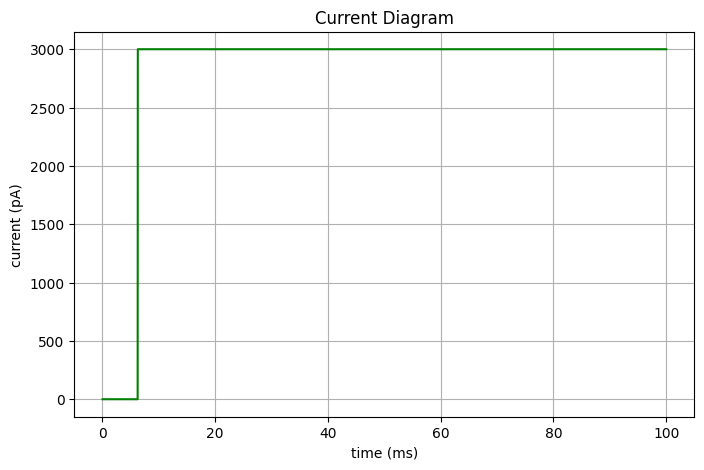

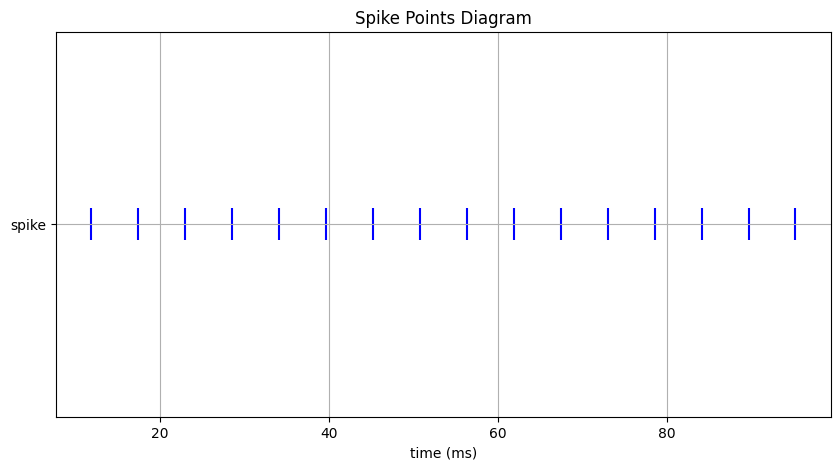

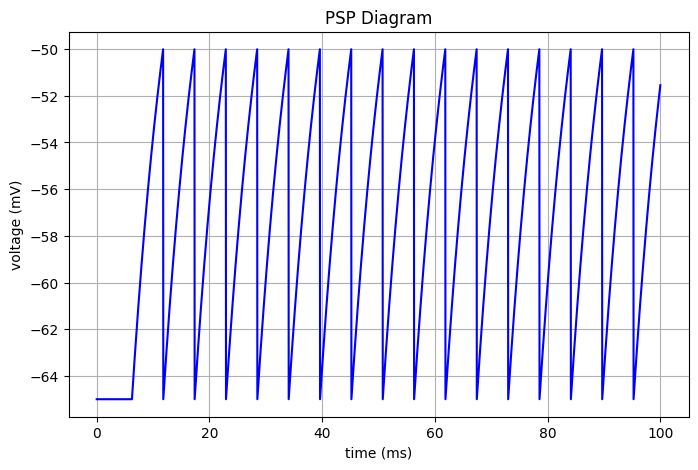

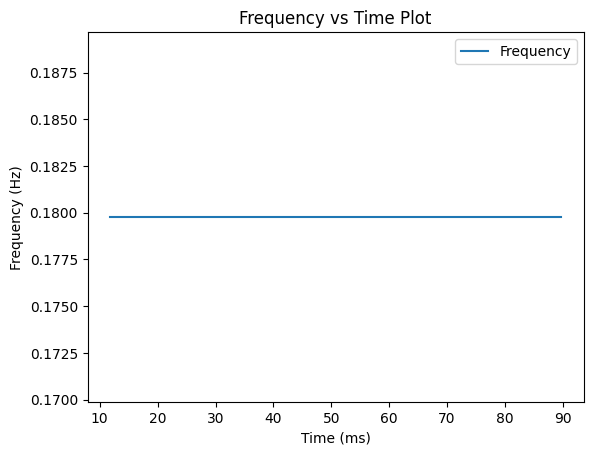

Iteration 0 completed.
***
 Iteration 1: Current = 4000 pA, Start time step = 220 ms 



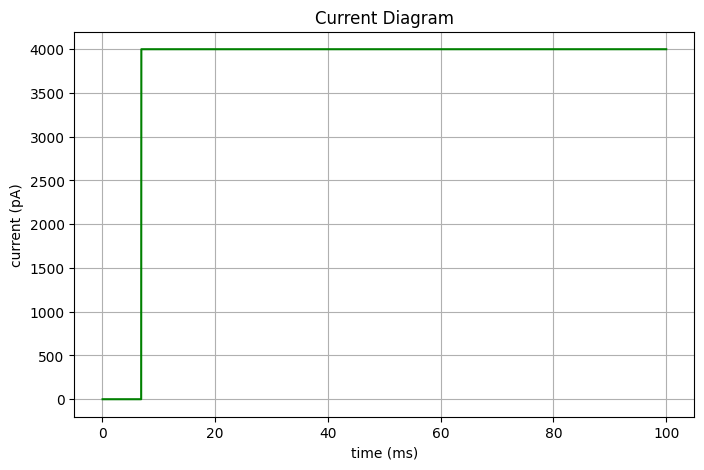

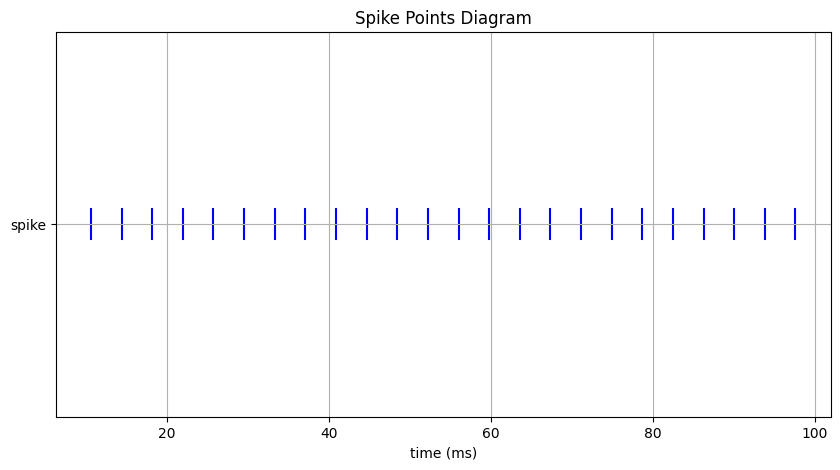

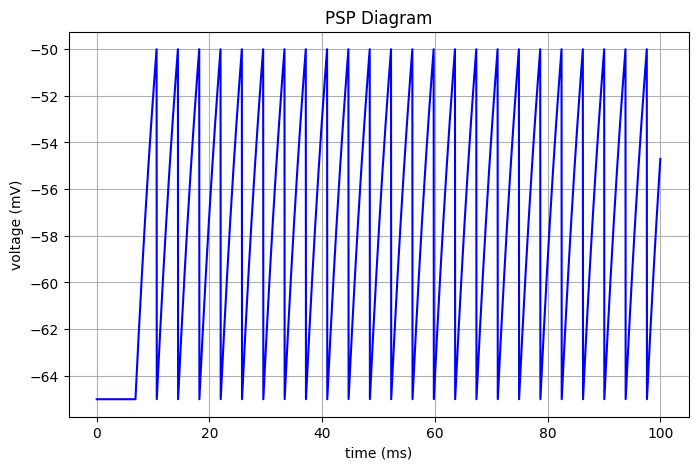

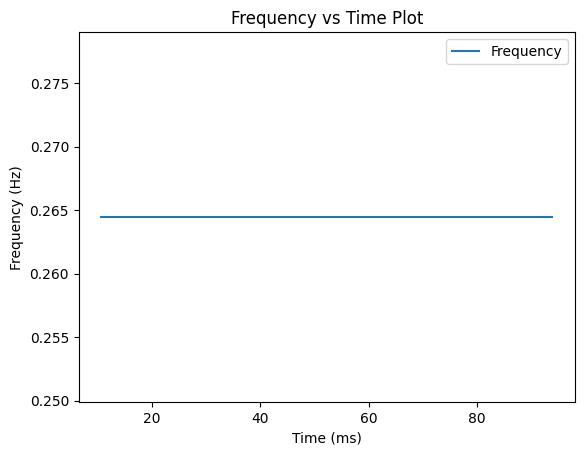

Iteration 1 completed.
***
 Iteration 2: Current = 5000 pA, Start time step = 240 ms 



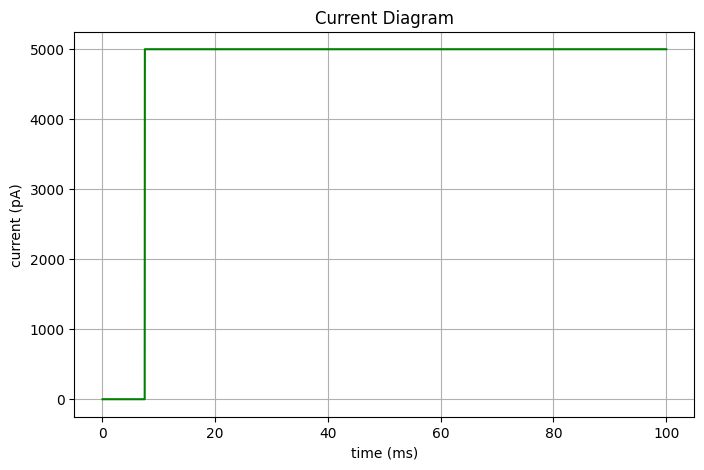

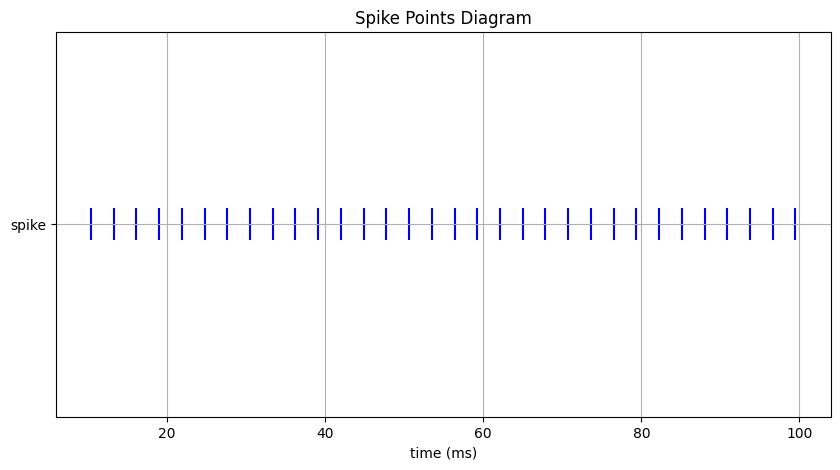

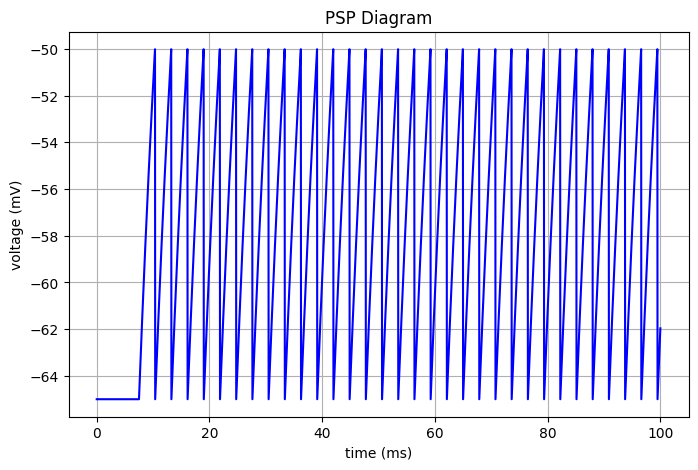

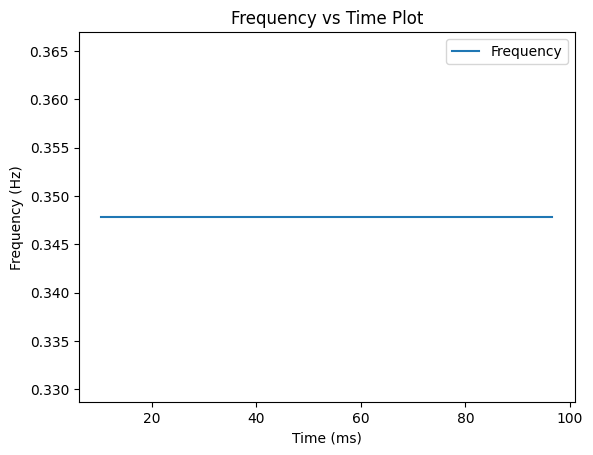

Iteration 2 completed.
***
 Iteration 3: Current = 6000 pA, Start time step = 260 ms 



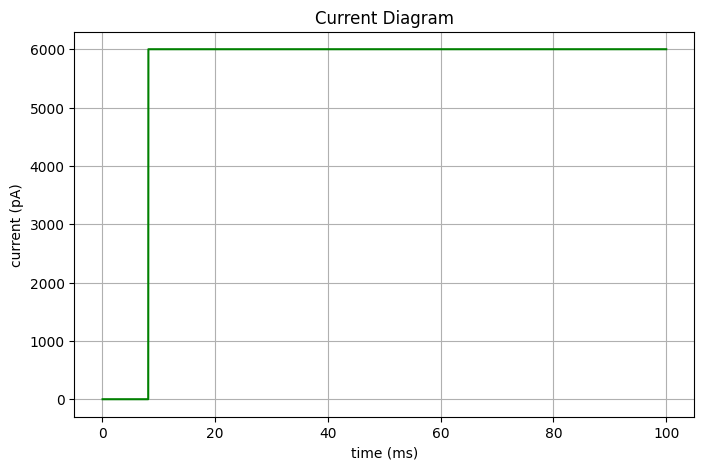

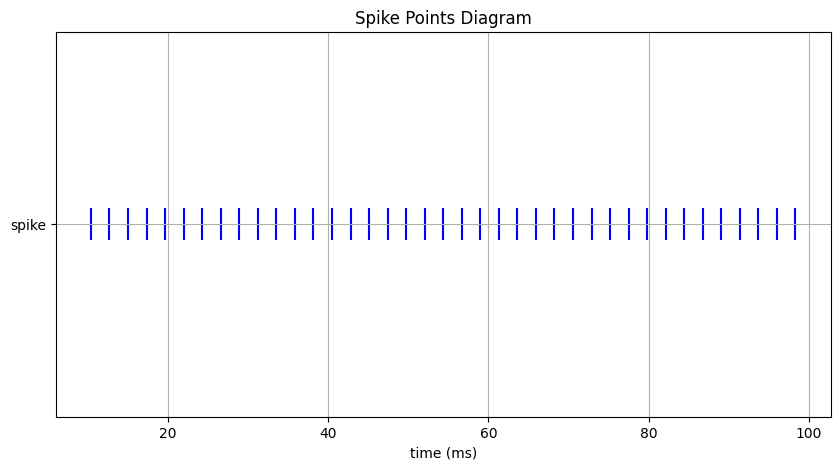

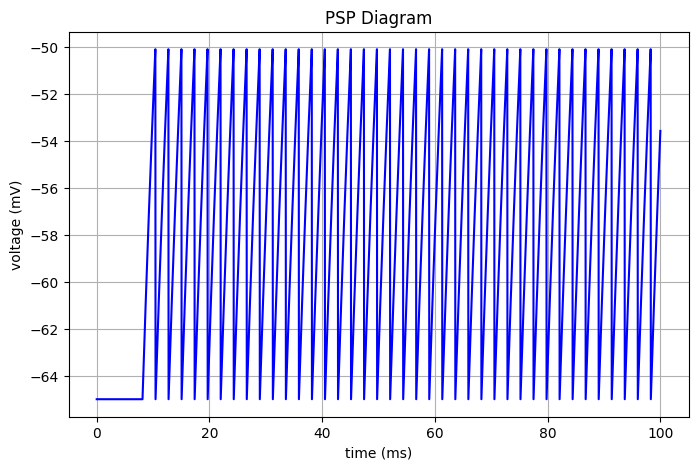

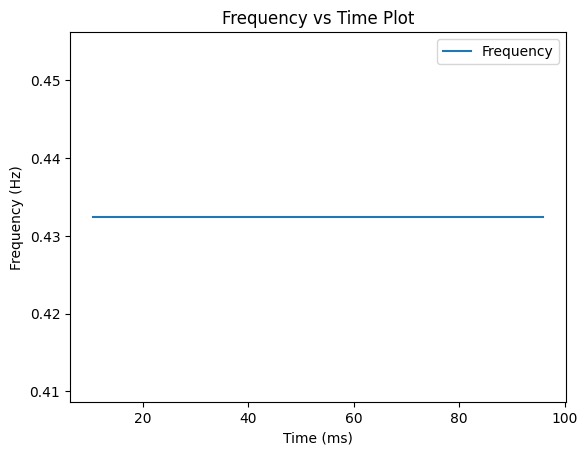

Iteration 3 completed.
***
 Iteration 4: Current = 7000 pA, Start time step = 280 ms 



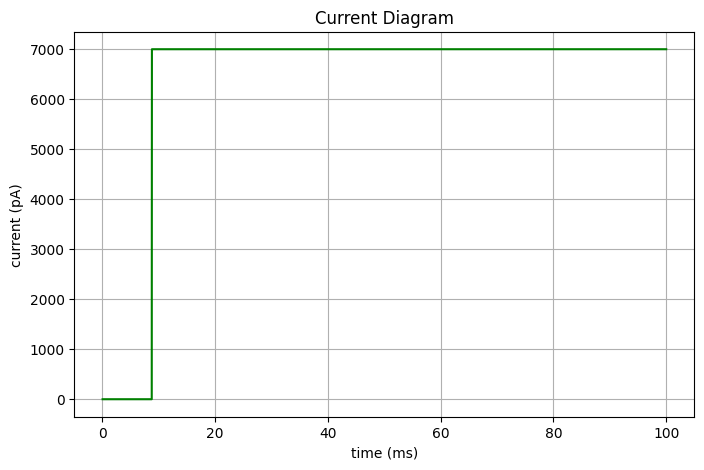

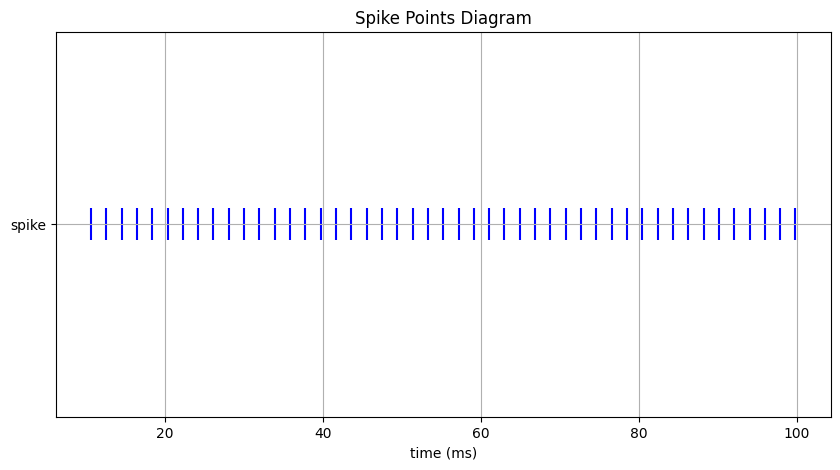

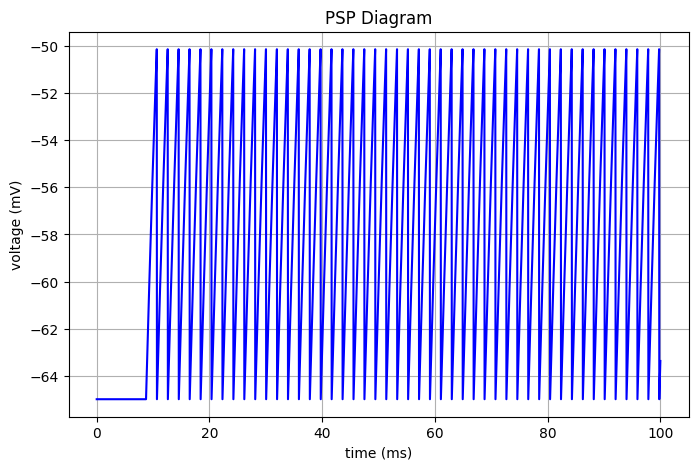

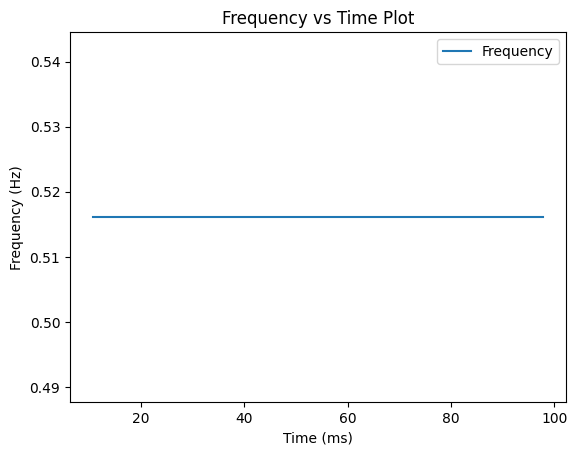

Iteration 4 completed.
***
 Iteration 5: Current = 8000 pA, Start time step = 300 ms 



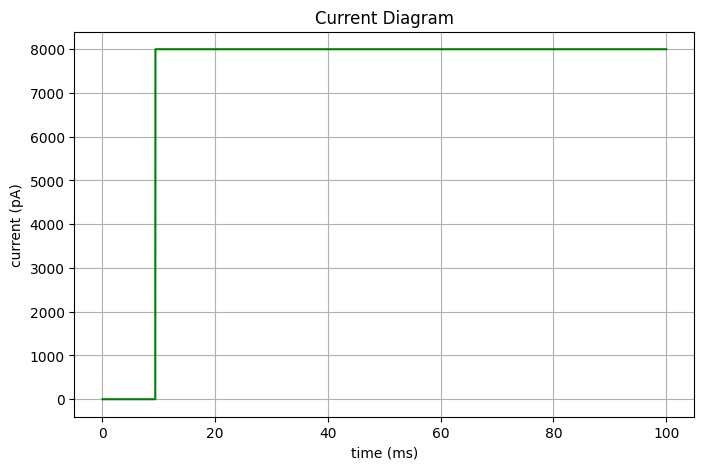

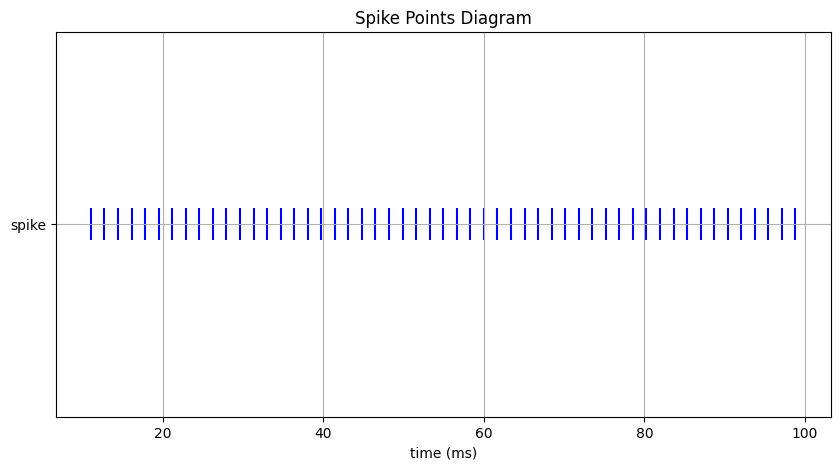

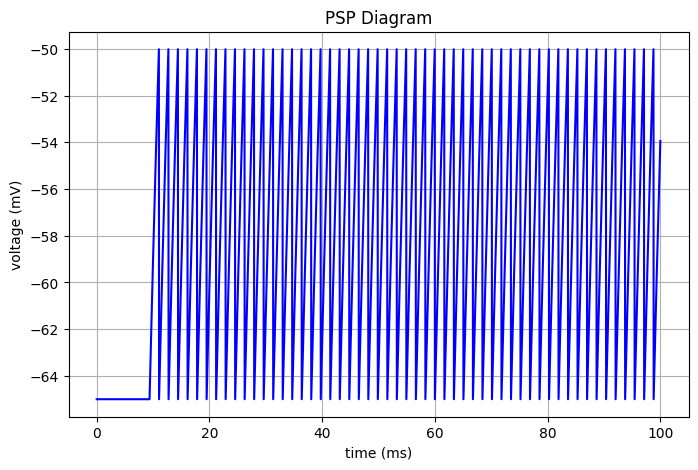

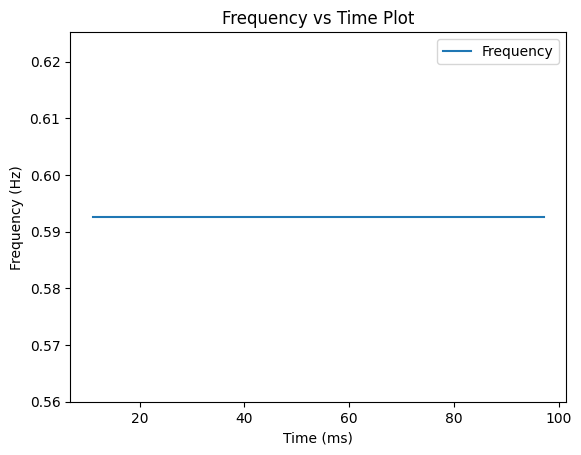

Iteration 5 completed.
***
 Iteration 6: Current = 9000 pA, Start time step = 320 ms 



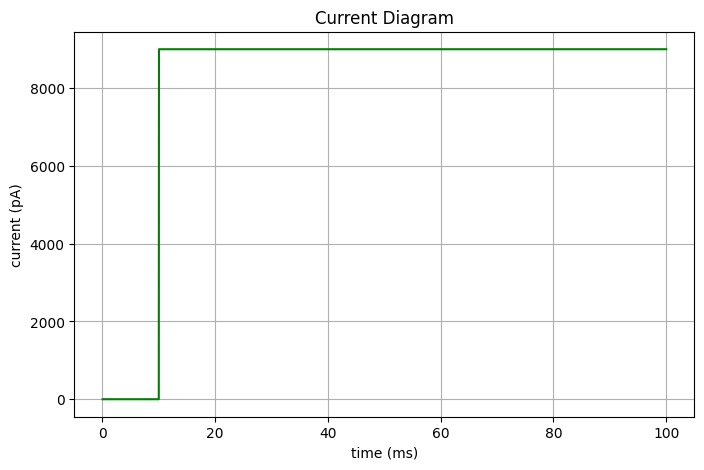

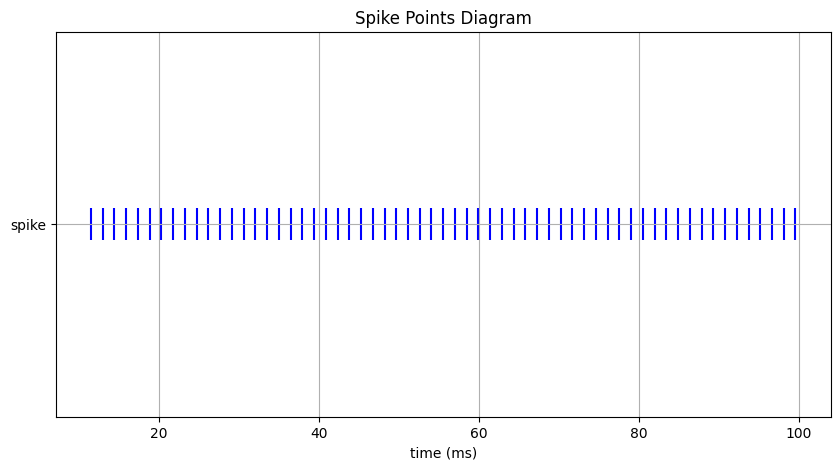

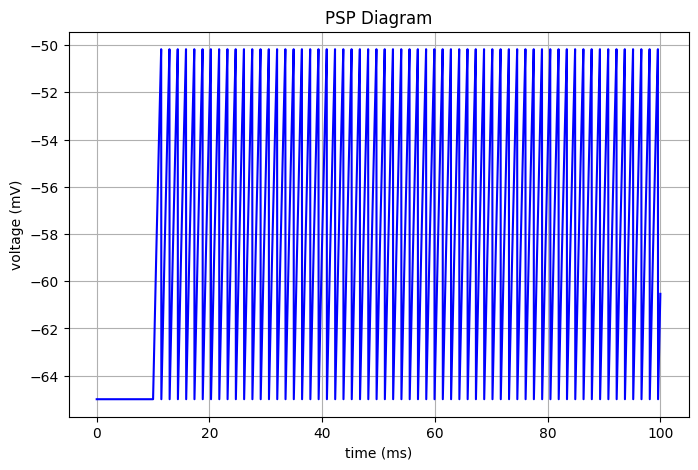

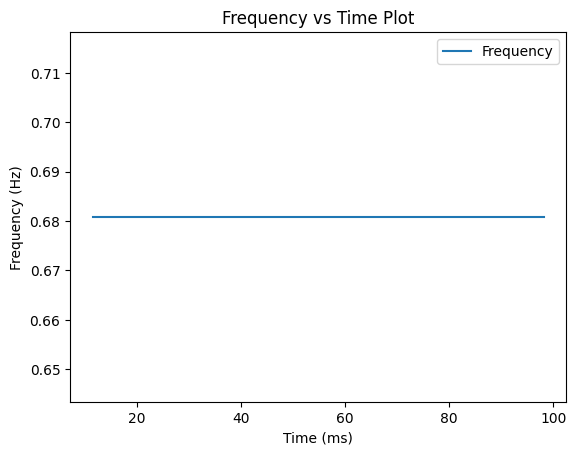

Iteration 6 completed.
***
 Iteration 7: Current = 10000 pA, Start time step = 340 ms 



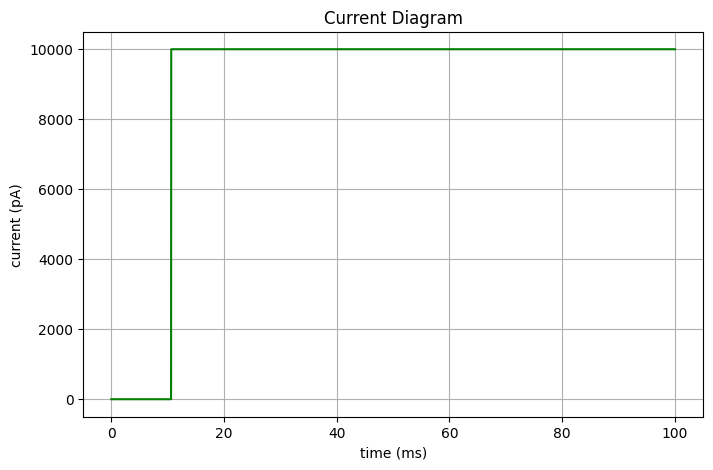

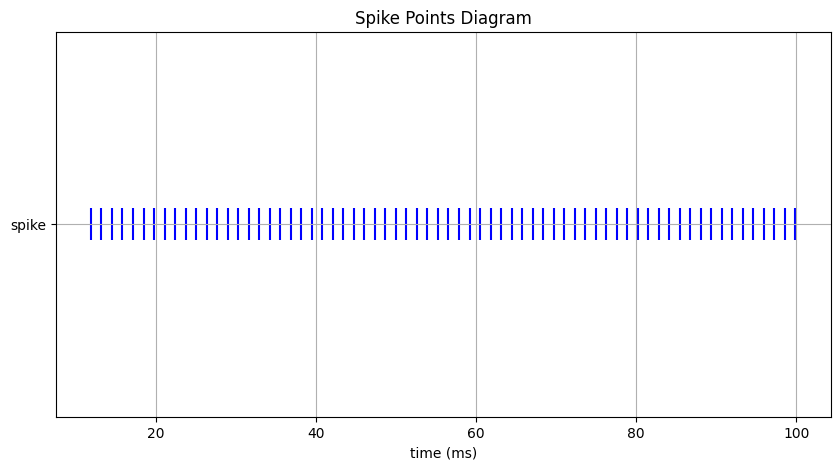

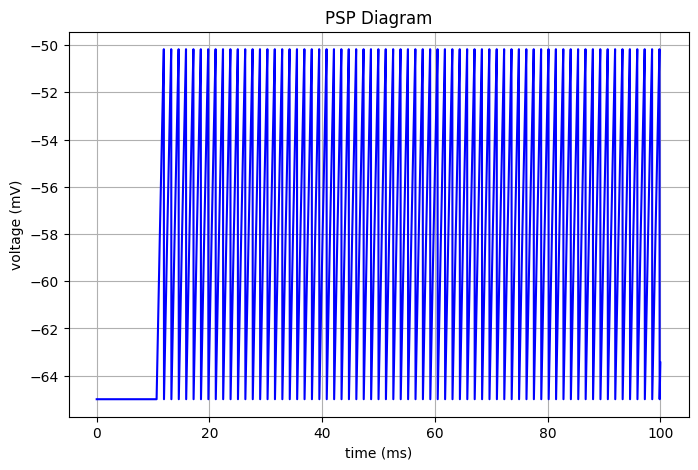

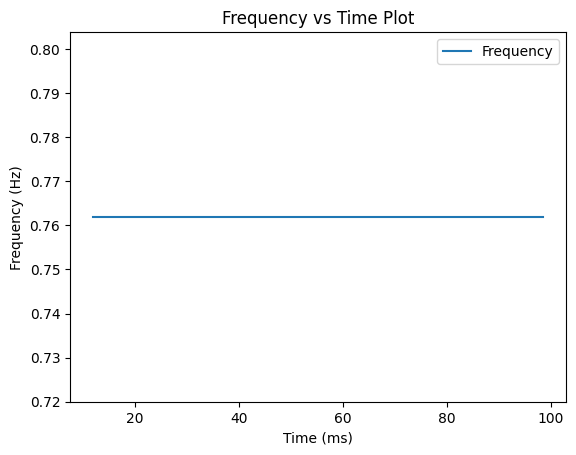

Iteration 7 completed.
***
 Iteration 8: Current = 11000 pA, Start time step = 360 ms 



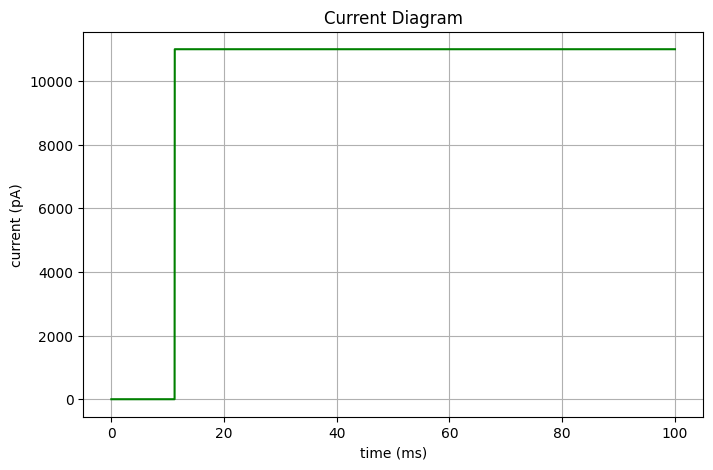

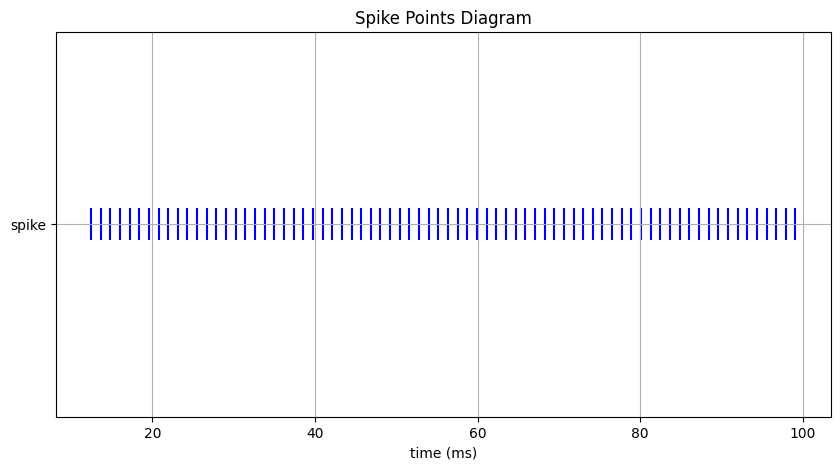

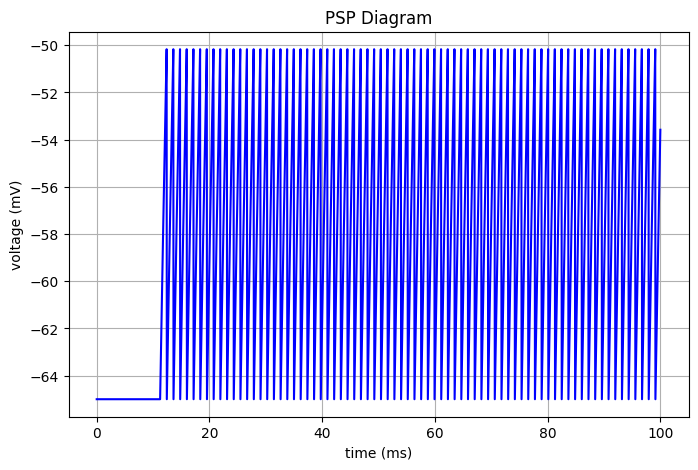

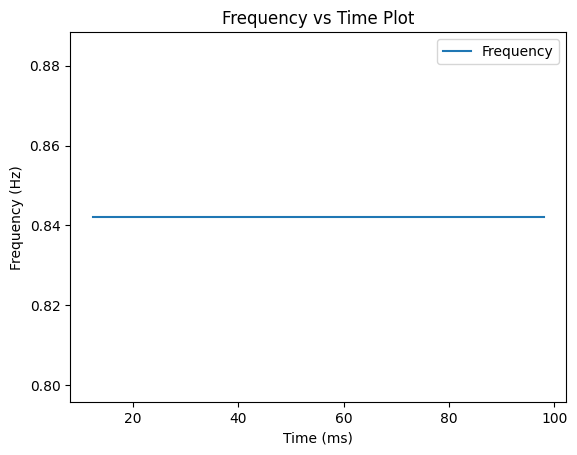

Iteration 8 completed.
***
 Iteration 9: Current = 12000 pA, Start time step = 380 ms 



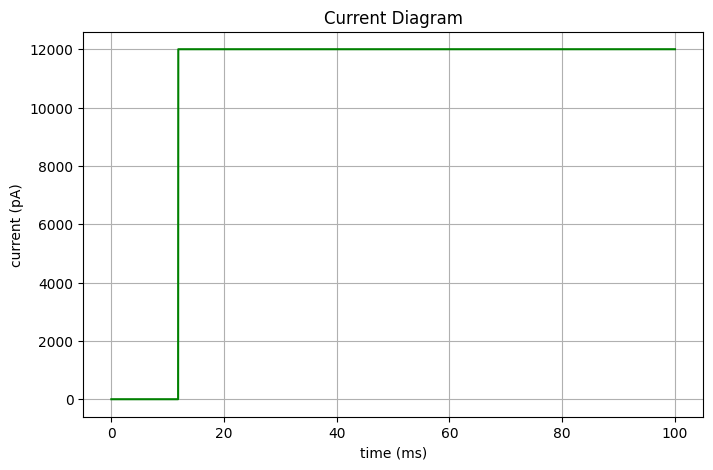

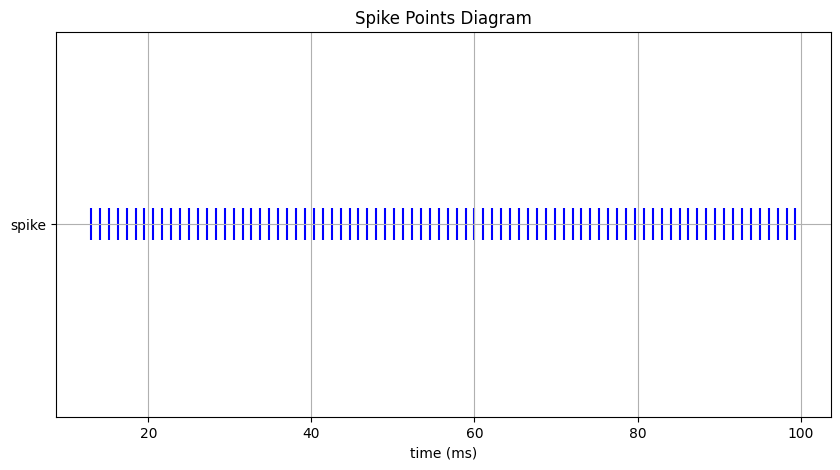

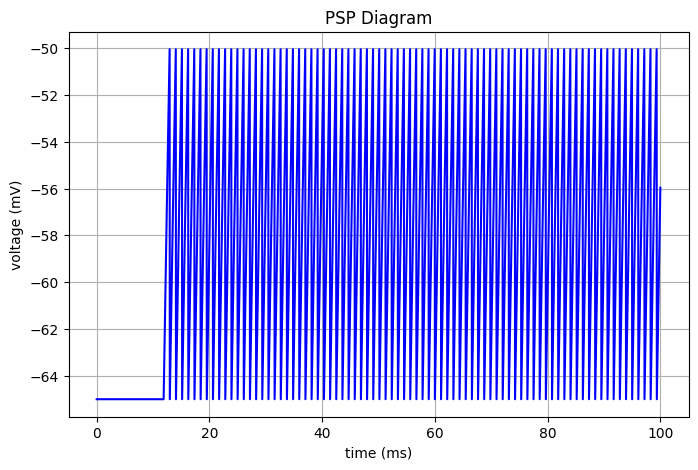

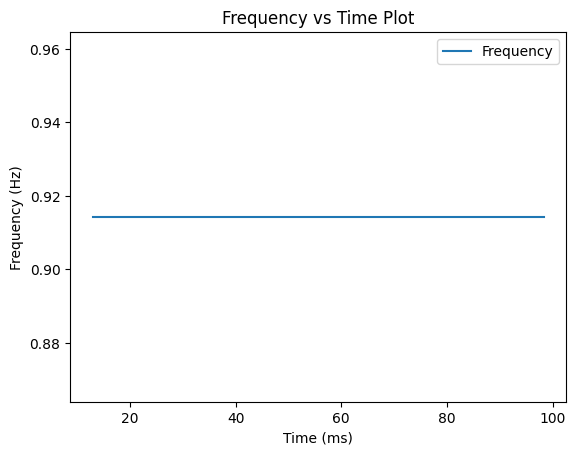

Iteration 9 completed.
***
 F-I curve for all previous currents


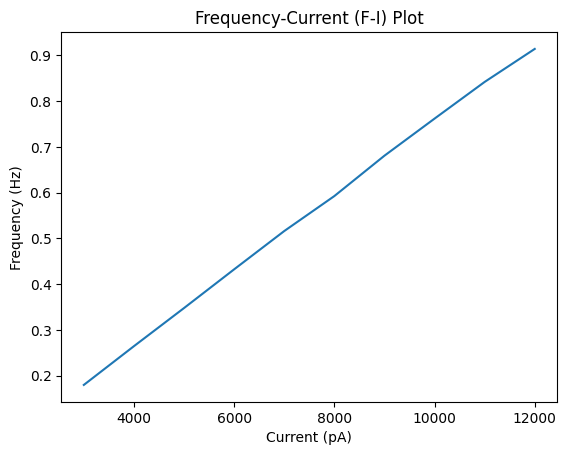

In [ ]:

# Set the initial values for the first current and start time step
first_start, first_cur = 200, 3000

# Define the number of different currents to test
n_currs = 10

# Initialize empty lists for the currents and models
currs , models = [], []

# Initialize an array to store the (current, frequency) pairs for each current
FI = np.zeros([n_currs, 2])

# Loop over the number of currents to test
for i in range (n_currs):
    # Calculate the constant current and start time step for this iteration
    const_cur = first_cur + 1000*i
    start = first_start + 20*i

    # Print a message indicating the current and start time step for this iteration
    print('***\n Iteration {}: Current = {} pA, Start time step = {} ms \n'.format(i, const_cur, start))

    # Generate the current DataFrame and LIF model for this iteration
    cur = current_df_gen(const_cur, start)
    model = LIF()

    # Append the current and model to their respective lists
    currs.append(cur)
    models.append(model)

    # Run the LIF model with the current as input and extract the times, currents, and frequencies
    times, currents, freqs = model_run(cur, model, i)
    # Store the final (current, frequency) pair in the FI array
    FI[i] = [currents[-1], freqs[-1]]

# Print a message indicating the F-I curve is being plotted
print('***\n F-I curve for all previous currents')

# Plot the F-I curve using the data stored in the FI array
plot_FI(FI)

## C) Part for noise

In [ ]:
def noisy_cur(amplitude=1, frequency=0.7, noise_std=0.23):

    # Generate time vector
    times = np.asarray([0.03125 * (x+1) for x in range(0, 3200)])

    # Generate sine wave pattern
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * times)
    # sine_wave = [0 for _ in range(start)] + [amplitude * (np.sin(2*np.pi*frequency*t)) +  for t in times]

    # Add noise to sine wave
    noise = 1000*np.random.normal(loc=0, scale=noise_std, size=len(sine_wave))
    signal = sine_wave + noise

    # Create DataFrame
    df = pd.DataFrame({'time(ms)': times, 'current(pA)': signal})

    return df

***
 iter 0: current noise std = 0.15 , current amplitude = 4000 



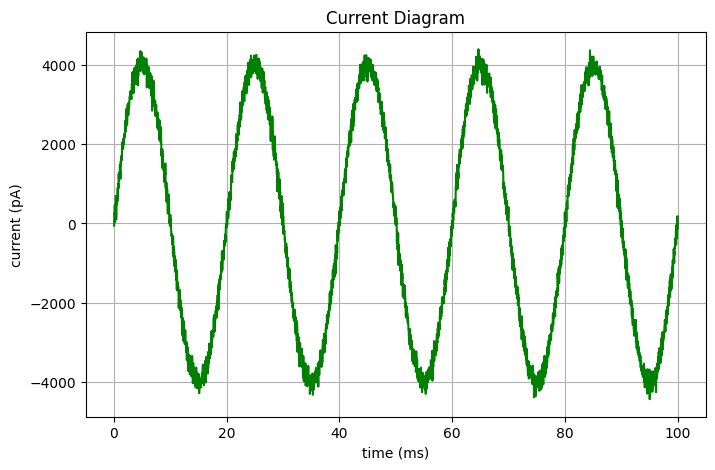

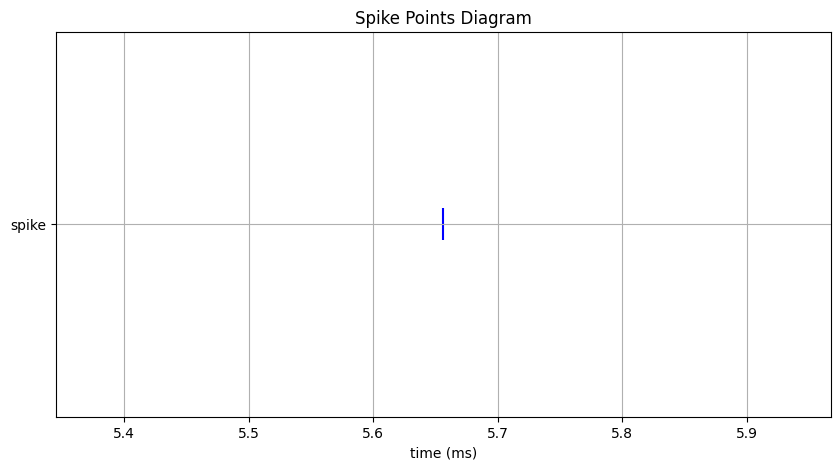

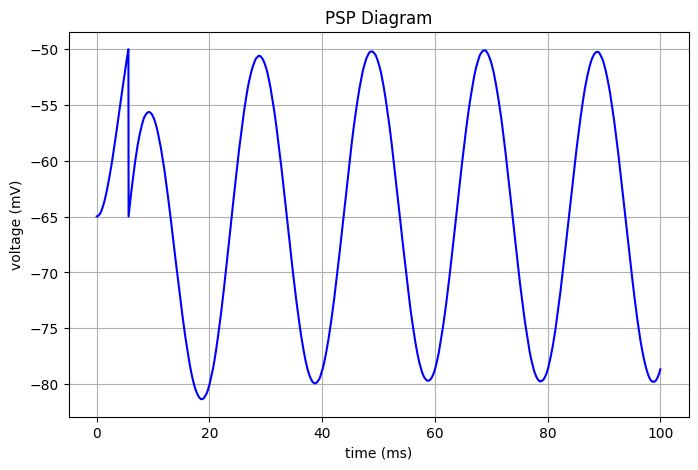

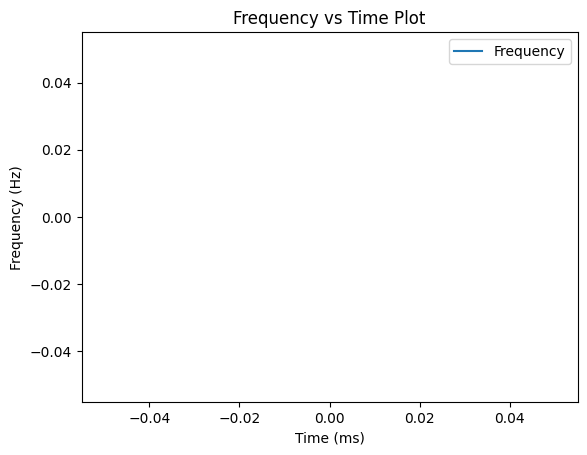

Iteration 0 completed.
***
 iter 1: current noise std = 0.35 , current amplitude = 5000 



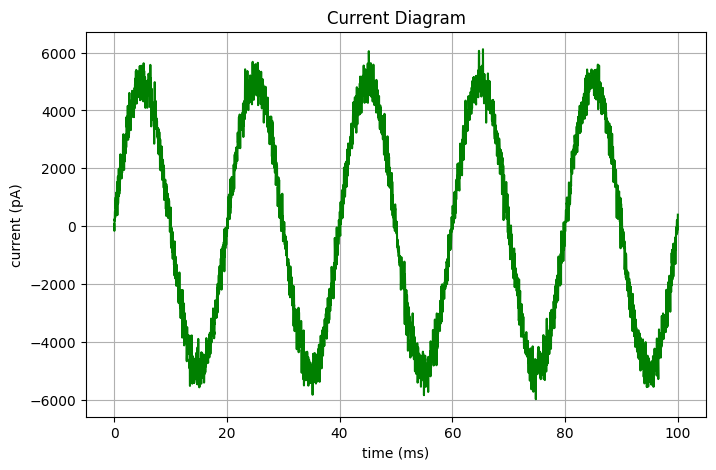

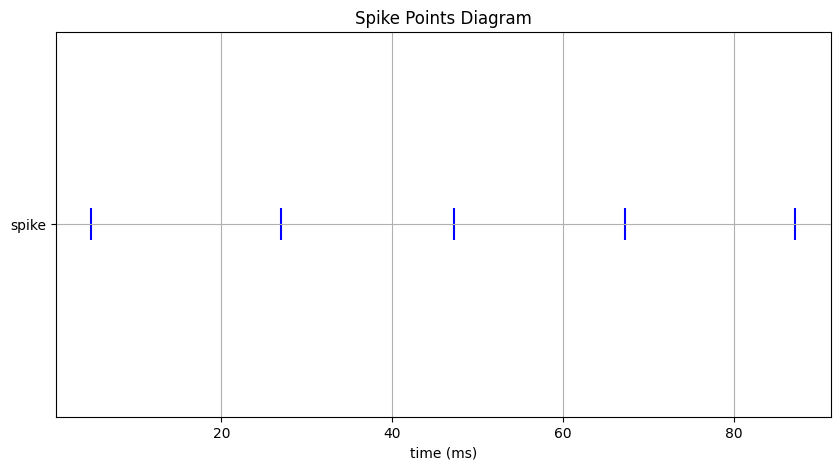

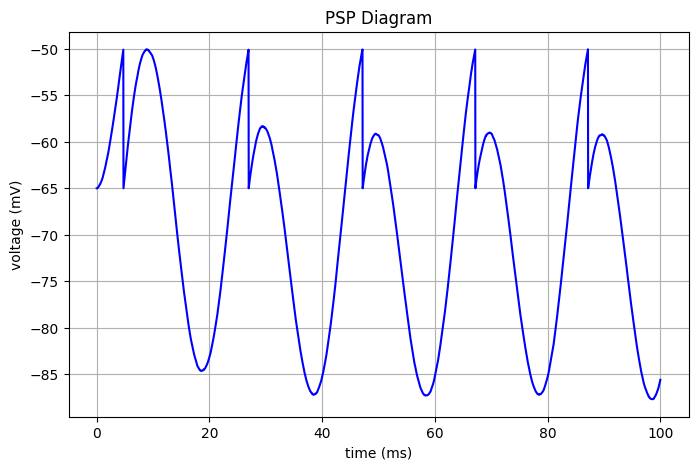

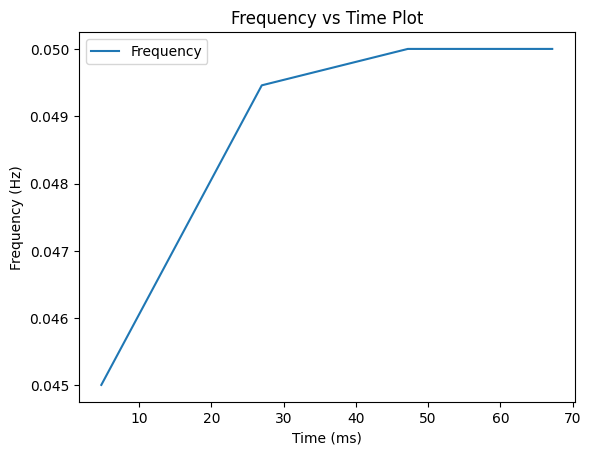

Iteration 1 completed.
***
 iter 2: current noise std = 0.55 , current amplitude = 6000 



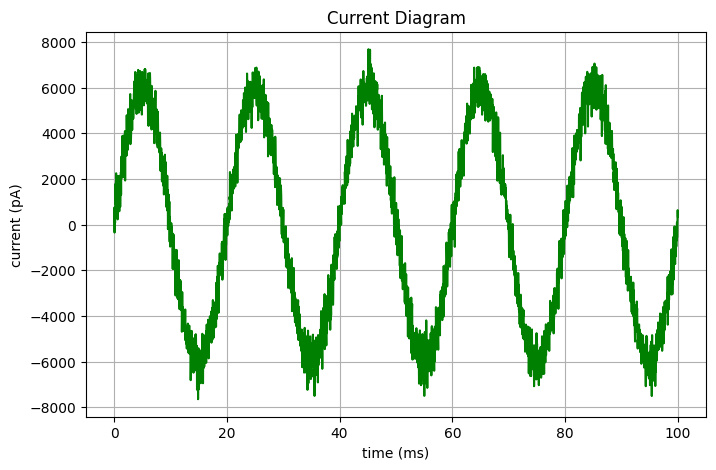

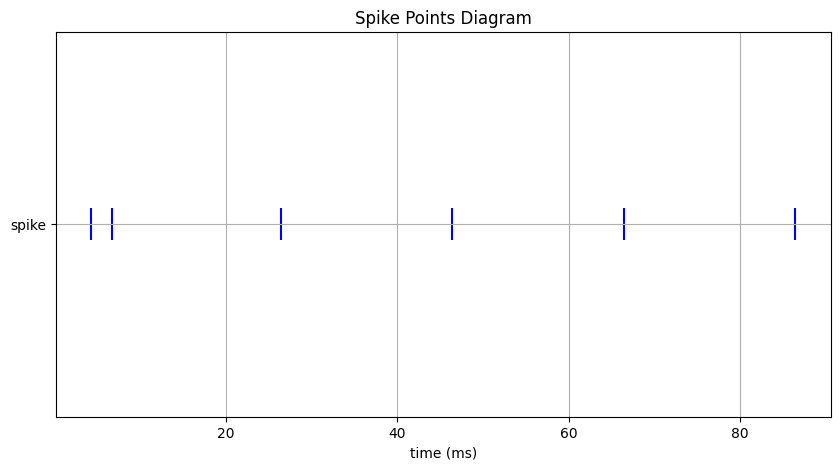

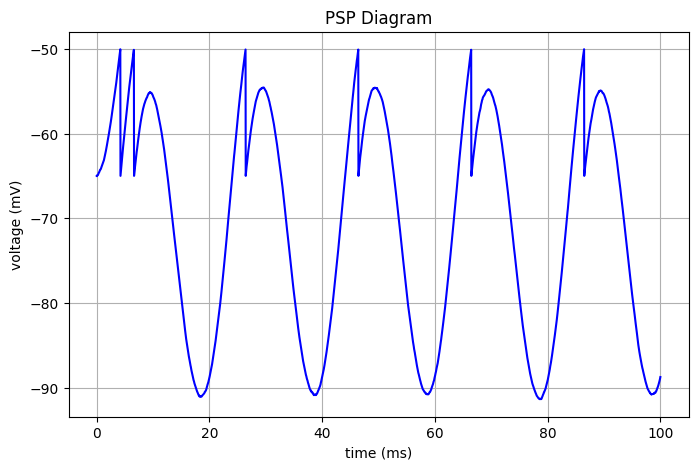

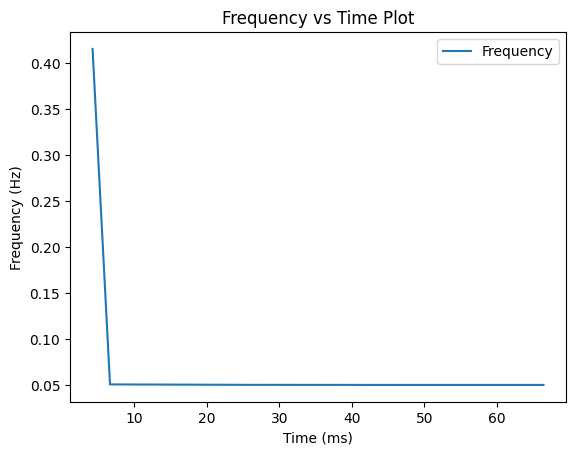

Iteration 2 completed.
***
 iter 3: current noise std = 0.7500000000000001 , current amplitude = 7000 



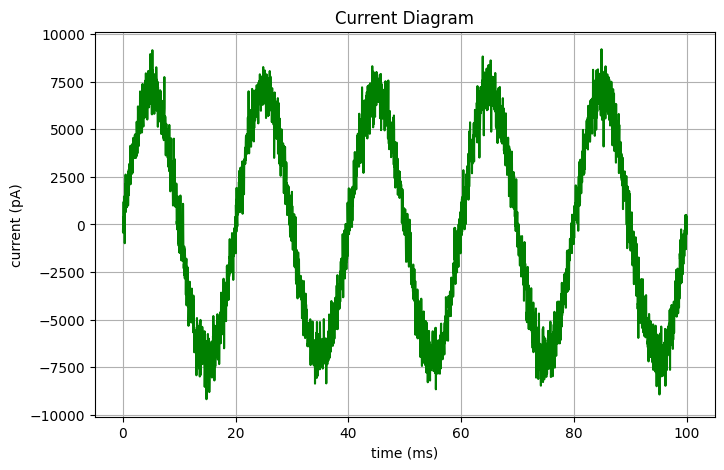

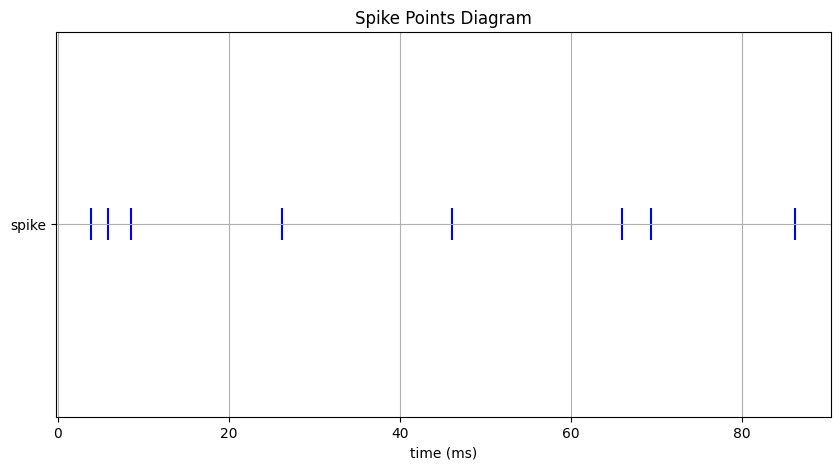

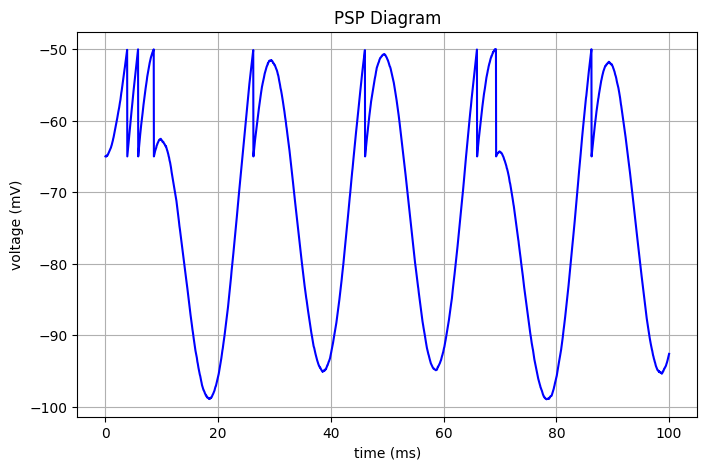

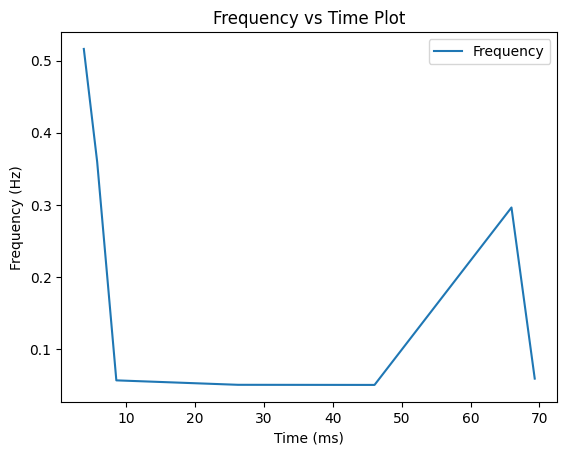

Iteration 3 completed.
***
 iter 4: current noise std = 0.9500000000000001 , current amplitude = 8000 



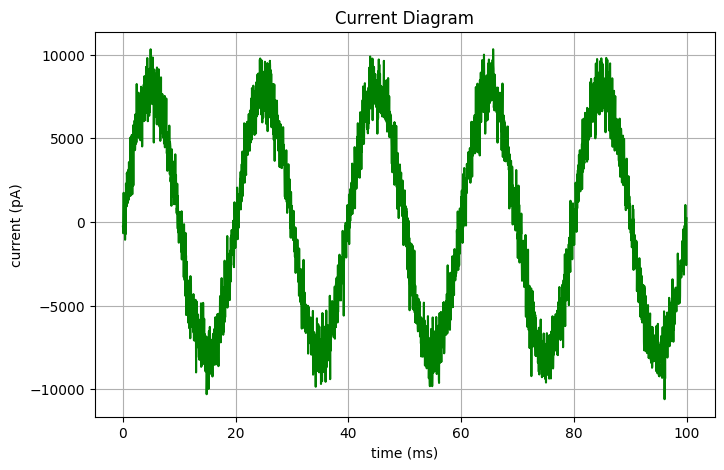

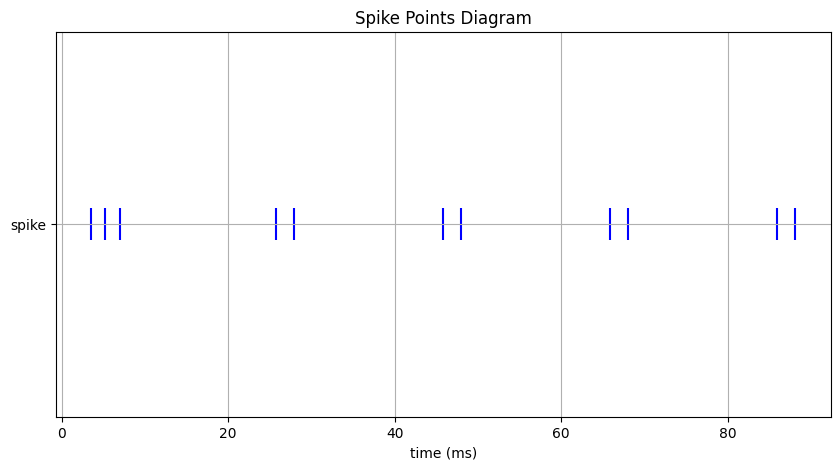

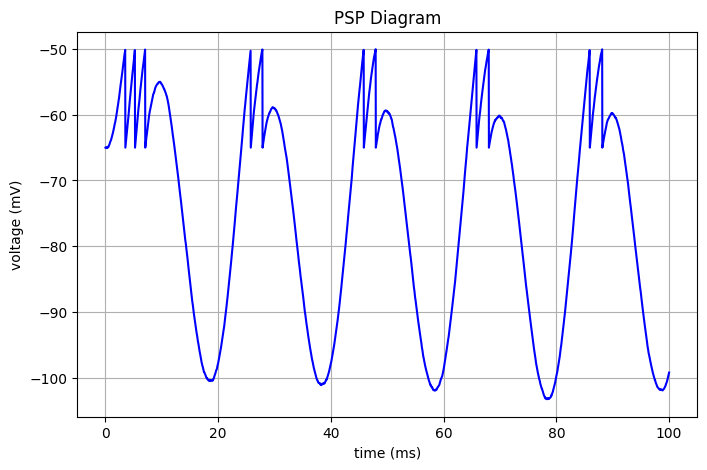

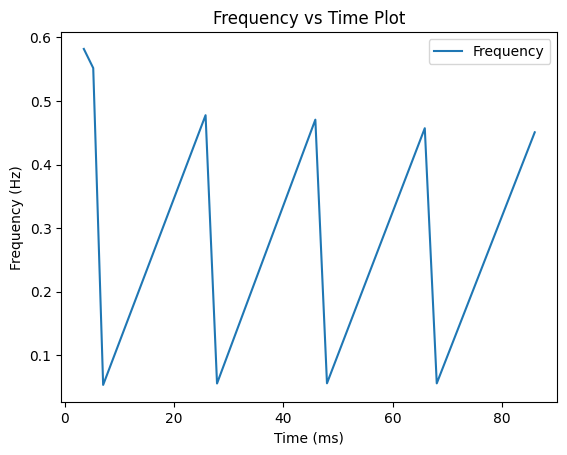

Iteration 4 completed.
***
 iter 5: current noise std = 1.15 , current amplitude = 9000 



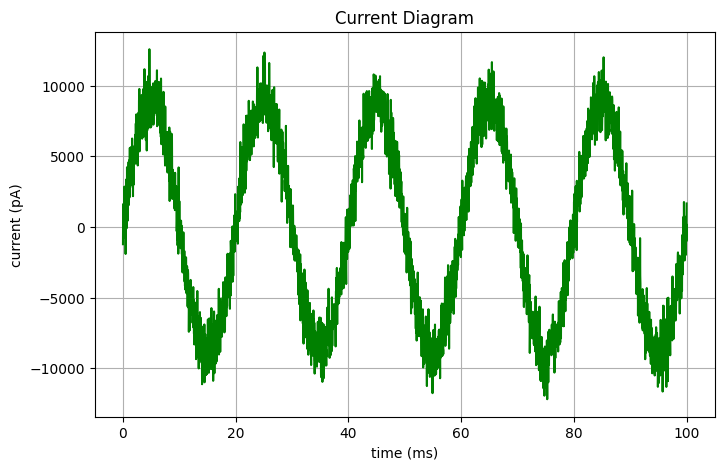

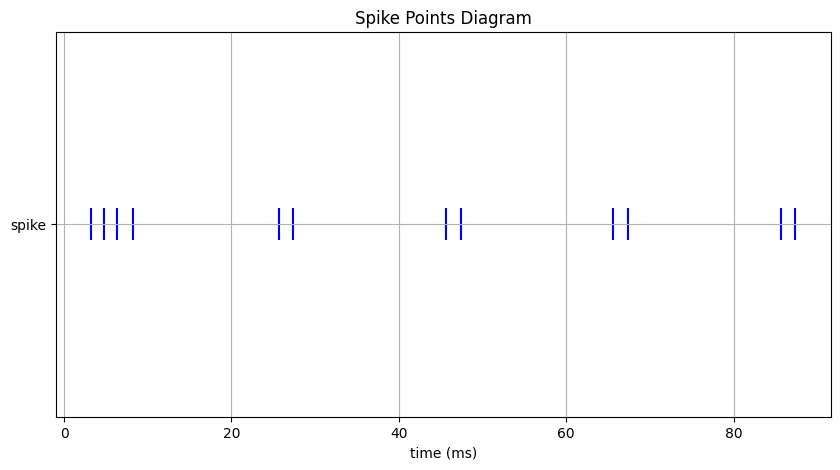

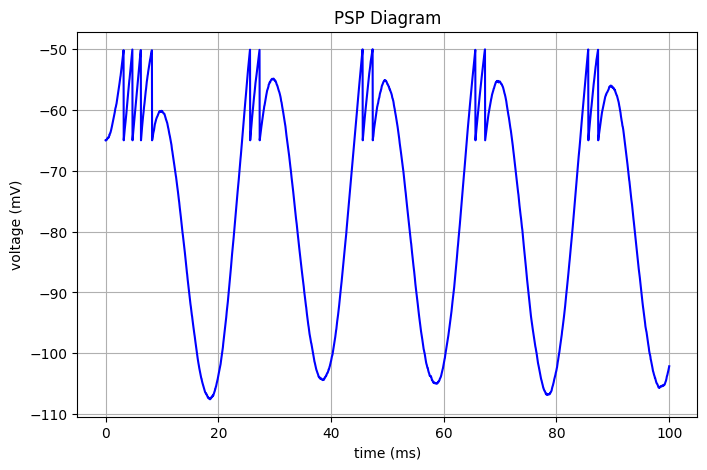

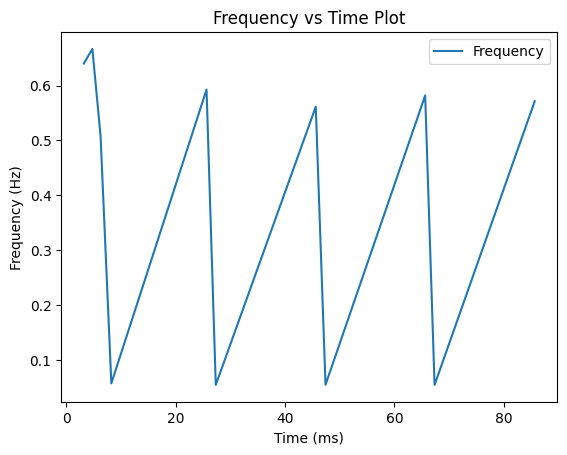

Iteration 5 completed.
***
 iter 6: current noise std = 1.35 , current amplitude = 10000 



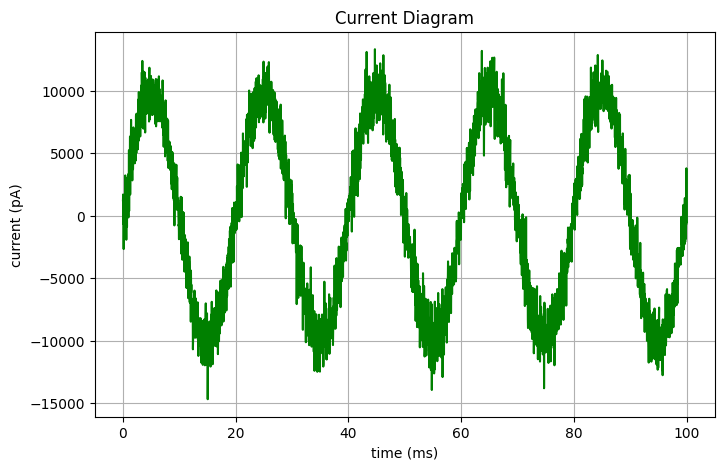

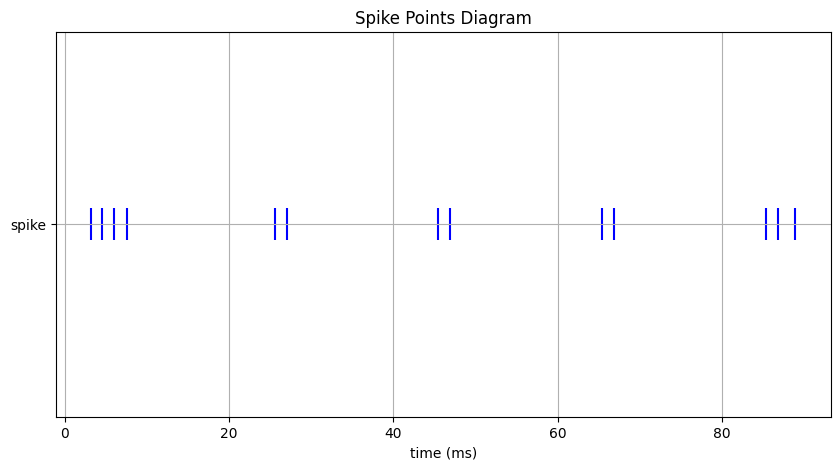

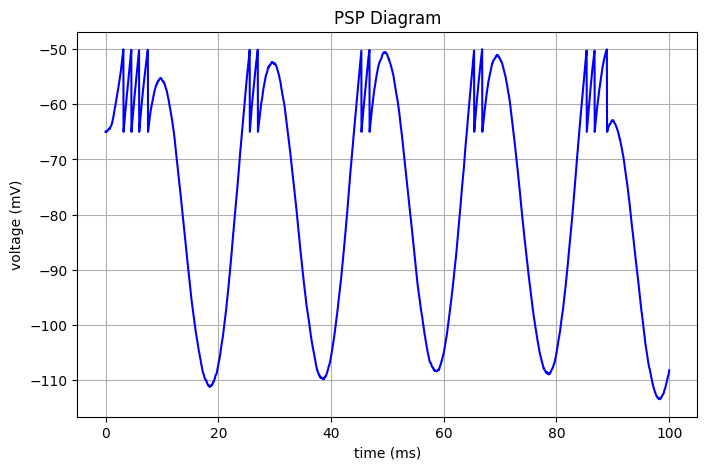

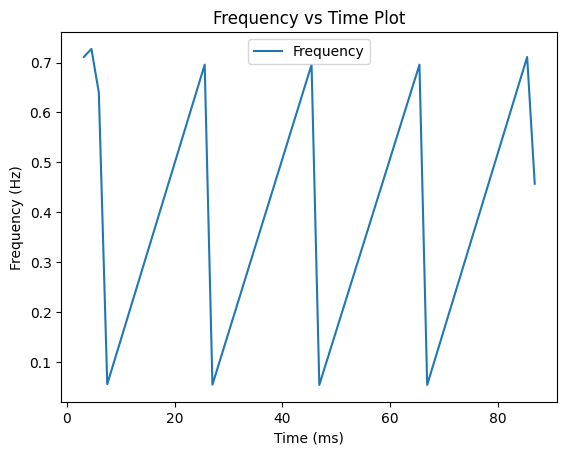

Iteration 6 completed.


In [ ]:
first_noise_std = 0.15
first_amp = 4000
n_currs = 7
currs , models = [], []
FI = np.zeros([n_currs, 2])
for i in range (n_currs):
    amp =  first_amp + 1000*i
    noise_std = first_noise_std + 0.2*i
    print('***\n iter {}: current noise std = {} , current amplitude = {} \n'.format(i, noise_std, amp))
    cur = noisy_cur(amplitude=amp, frequency=0.05, noise_std=noise_std)
    model = LIF()
    currs.append(cur)
    models.append(model)
    times, currents, freqs = model_run(cur, model, i)

***
 iter 0: current noise std = 0.0 , current amplitude = 8000 



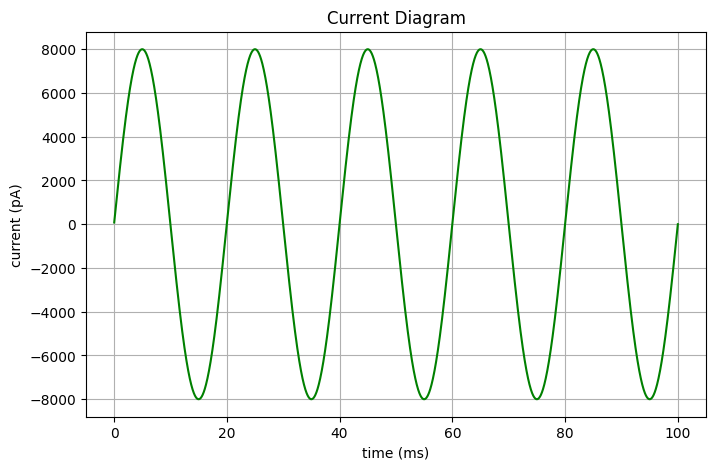

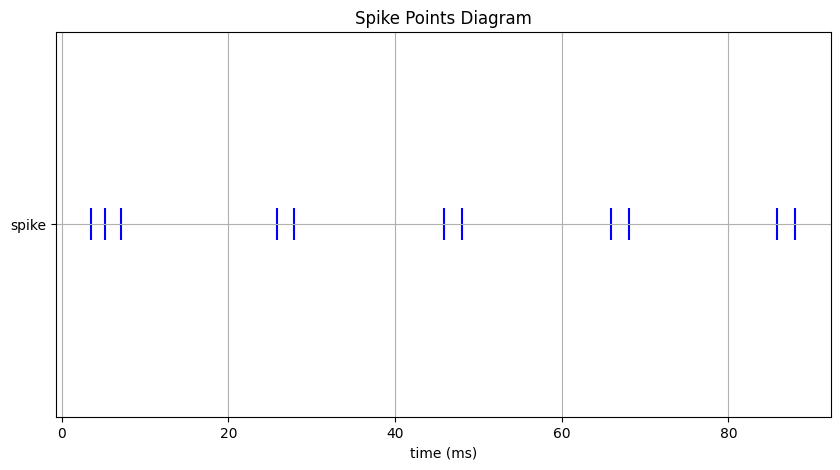

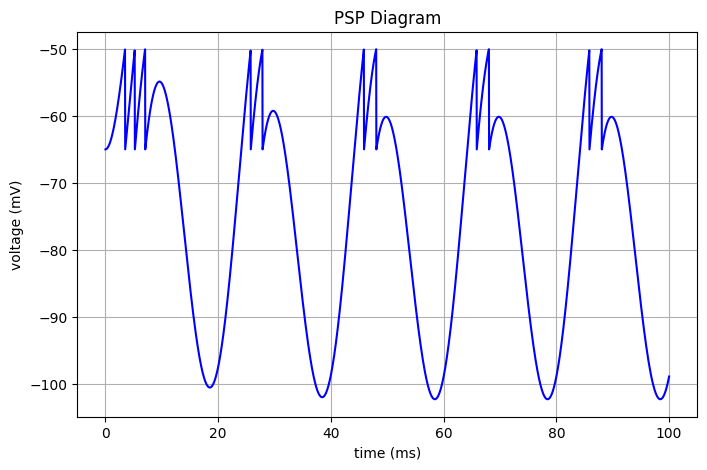

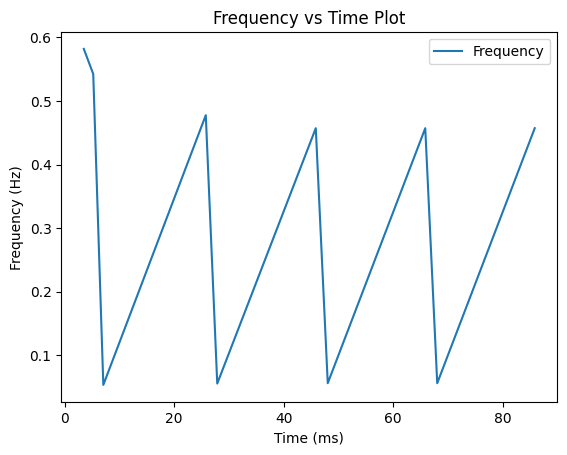

Iteration 0 completed.
***
 iter 1: current noise std = 0.0 , current amplitude = 9000 



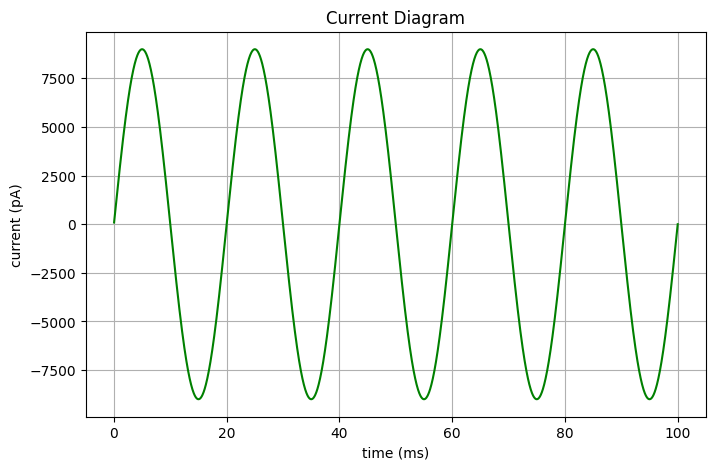

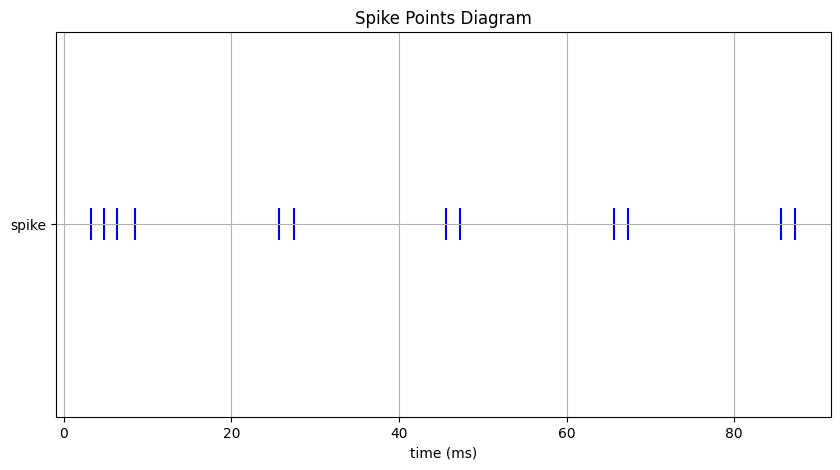

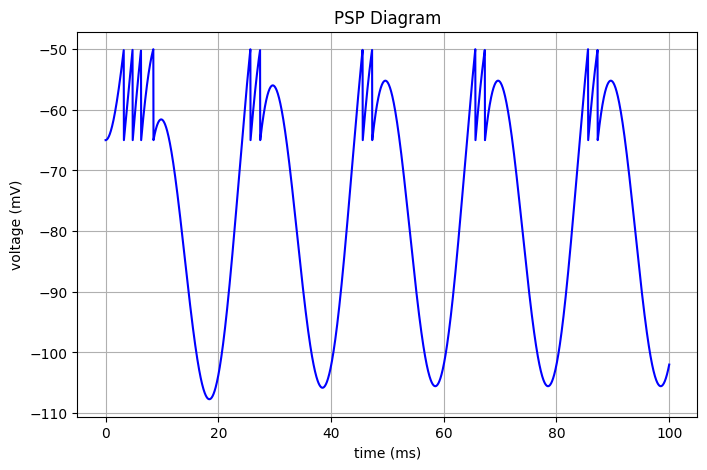

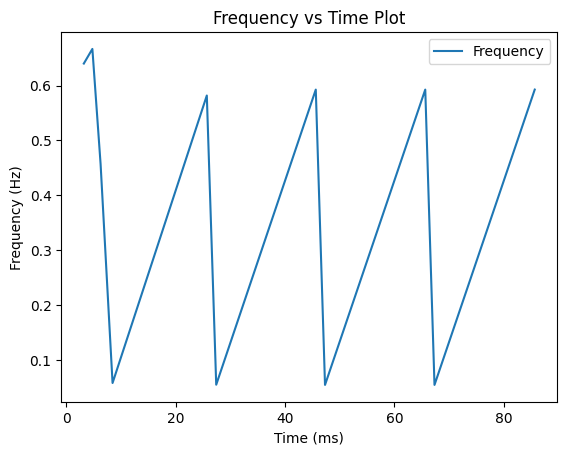

Iteration 1 completed.
***
 iter 2: current noise std = 0.0 , current amplitude = 10000 



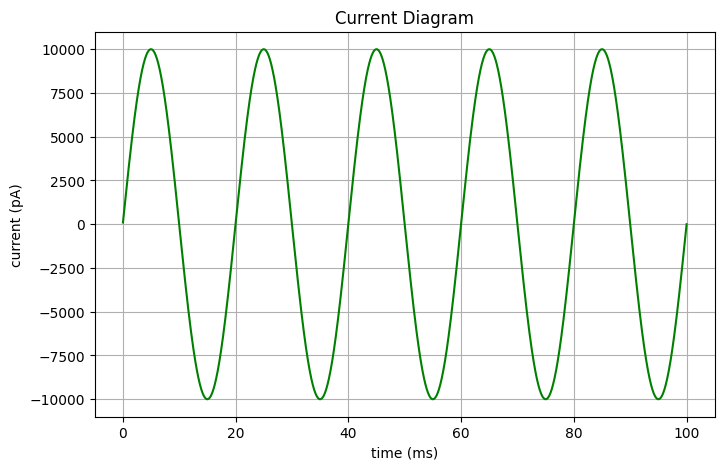

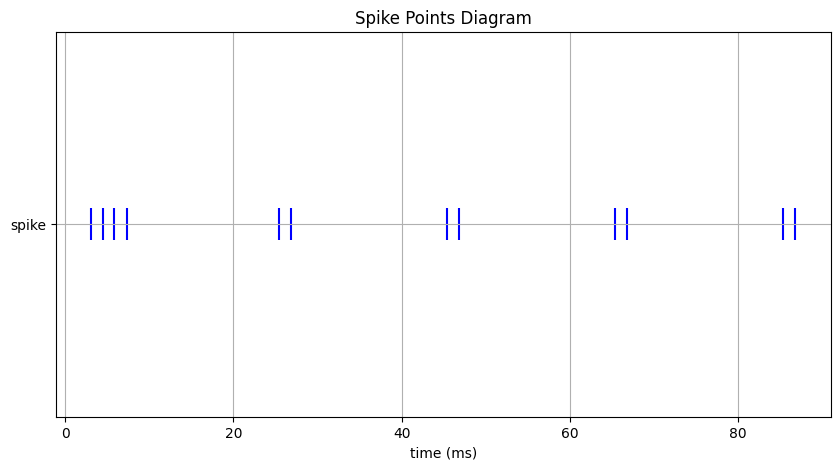

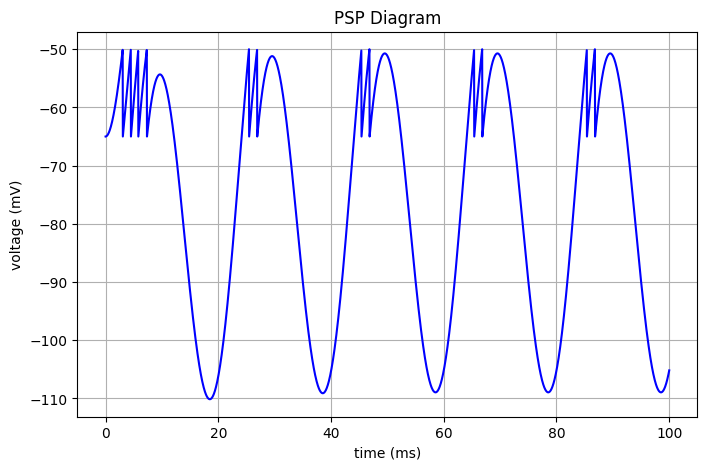

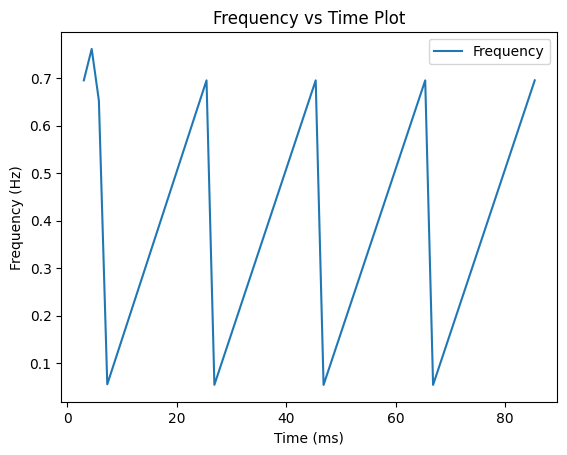

Iteration 2 completed.
***
 iter 3: current noise std = 0.0 , current amplitude = 11000 



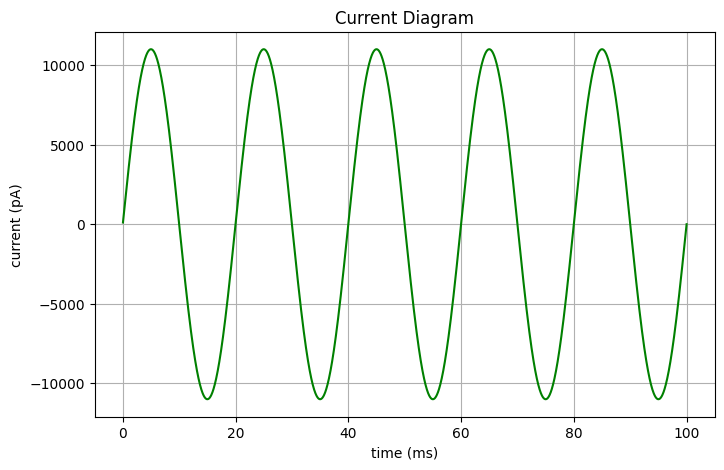

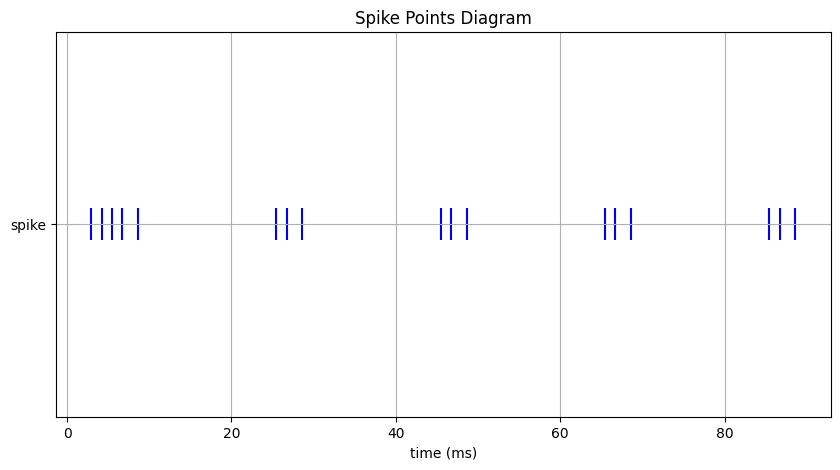

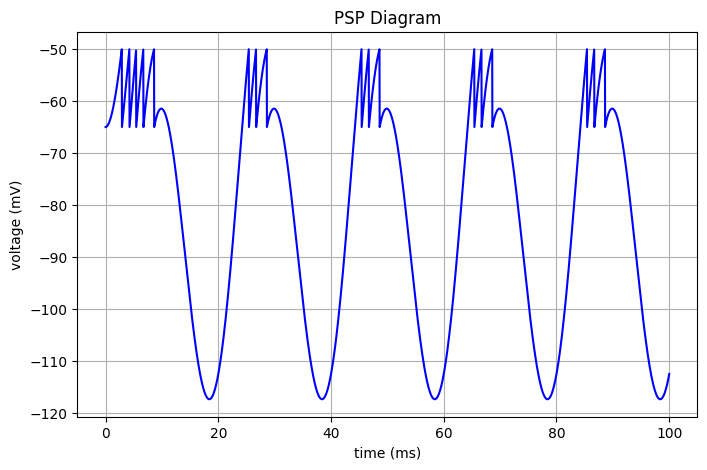

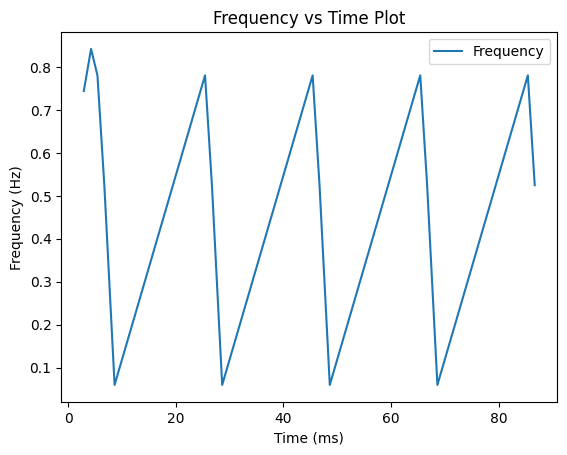

Iteration 3 completed.
***
 iter 4: current noise std = 0.0 , current amplitude = 12000 



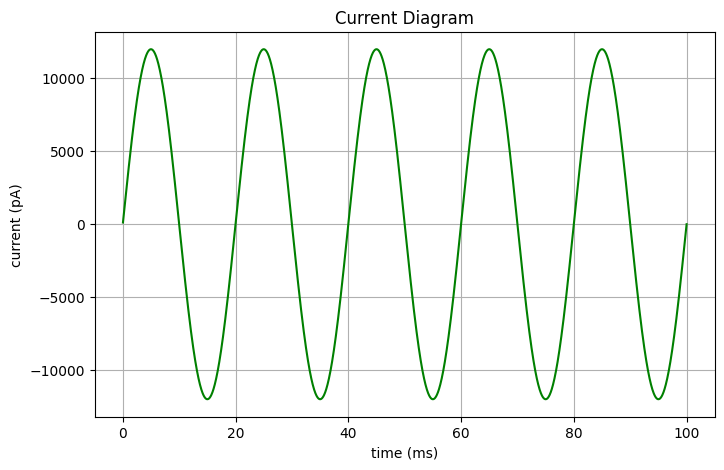

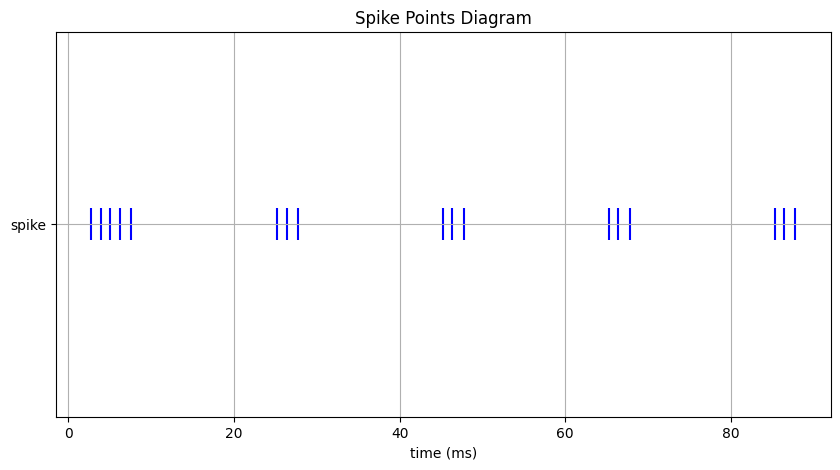

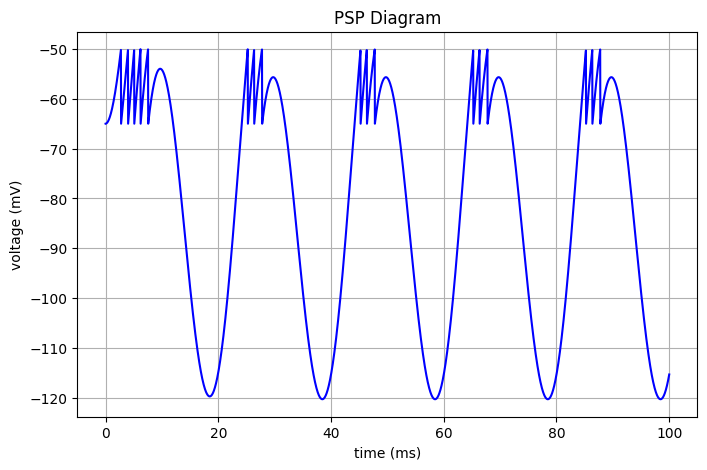

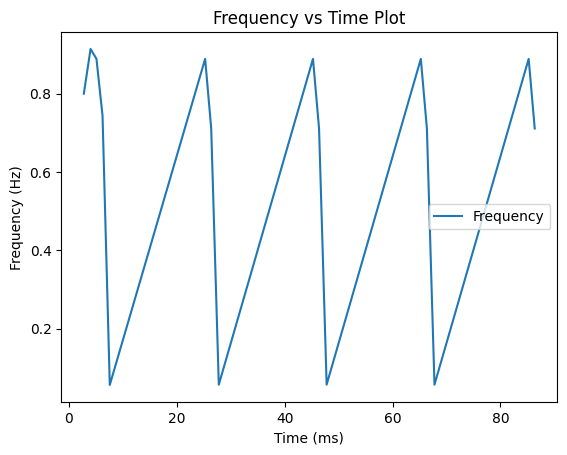

Iteration 4 completed.
***
 iter 5: current noise std = 0.0 , current amplitude = 13000 



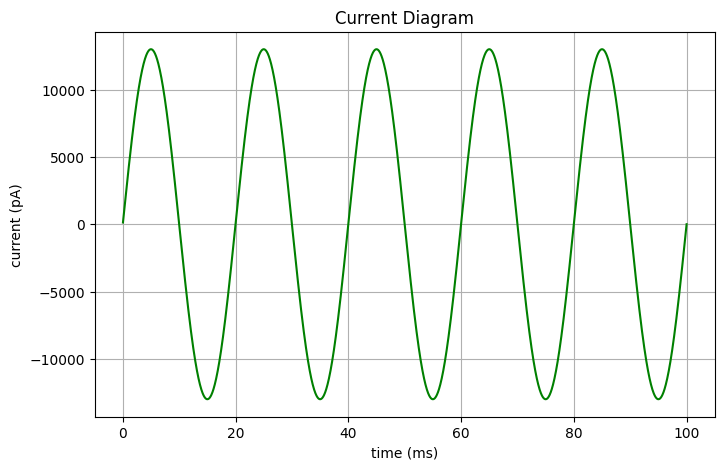

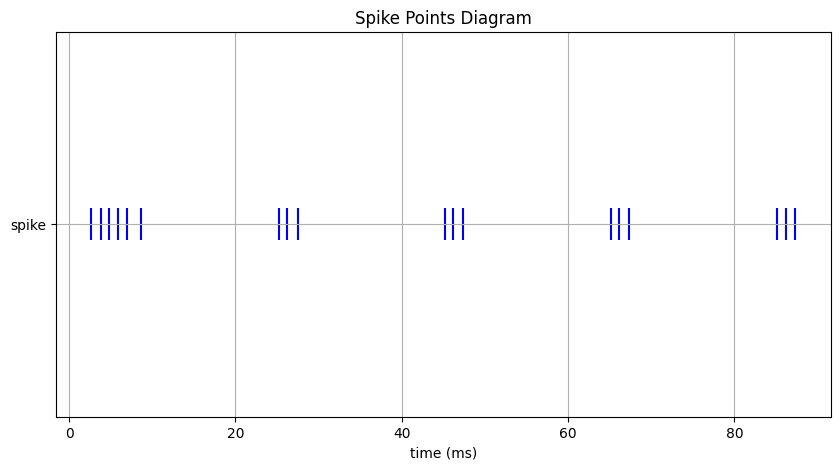

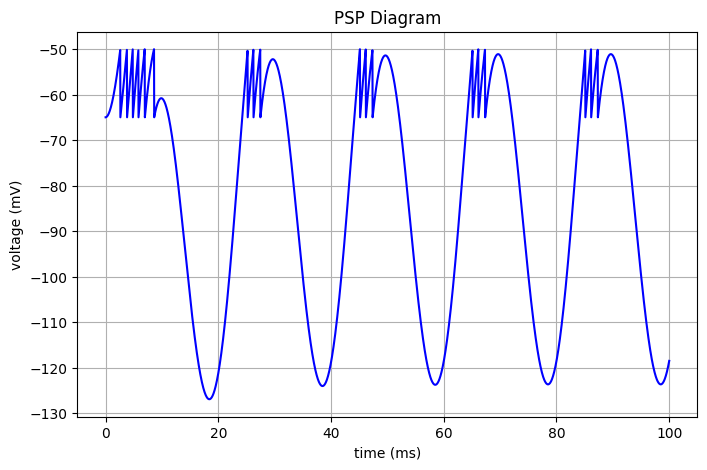

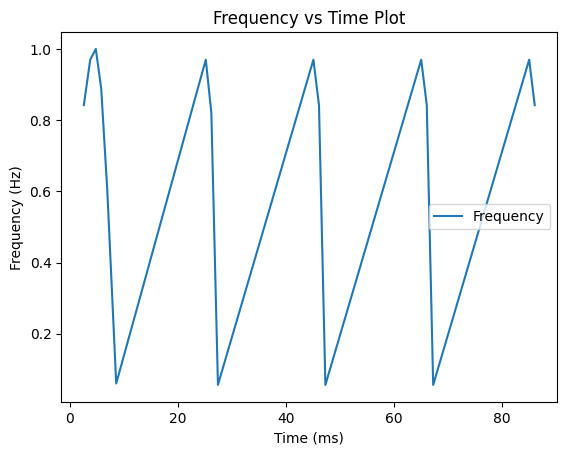

Iteration 5 completed.
***
 iter 6: current noise std = 0.0 , current amplitude = 14000 



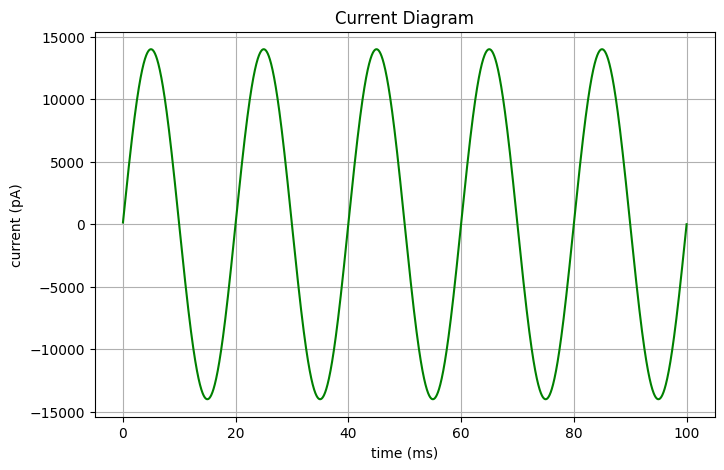

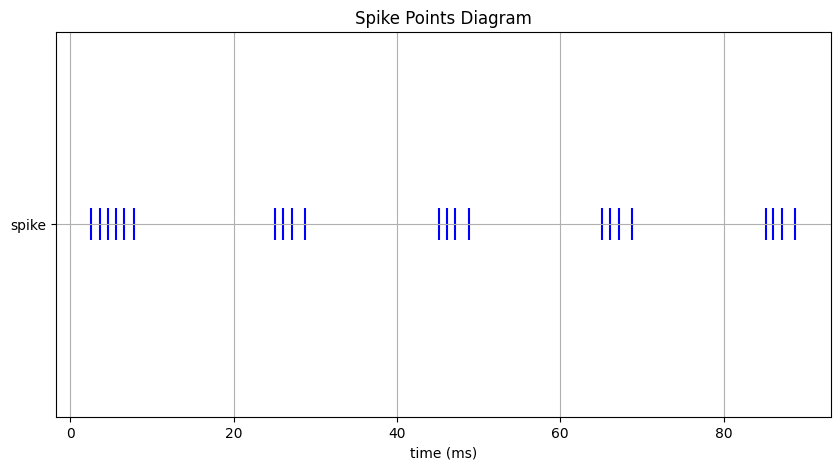

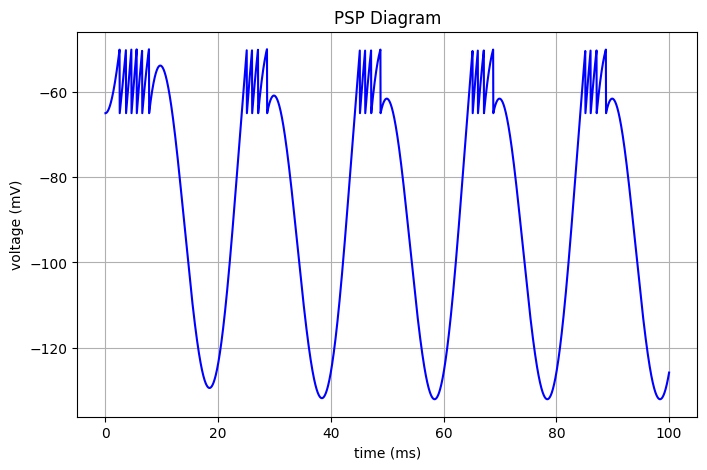

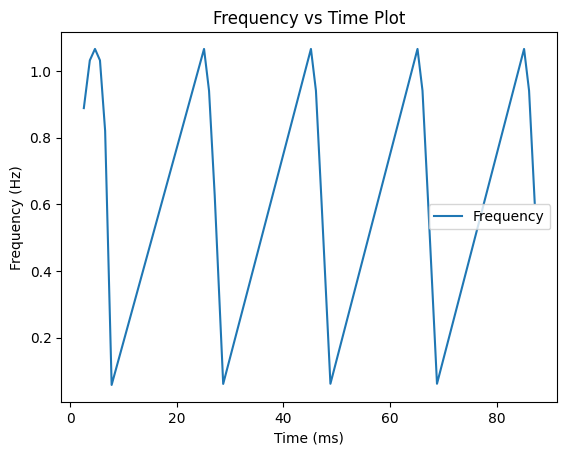

Iteration 6 completed.
***
 iter 7: current noise std = 0.0 , current amplitude = 15000 



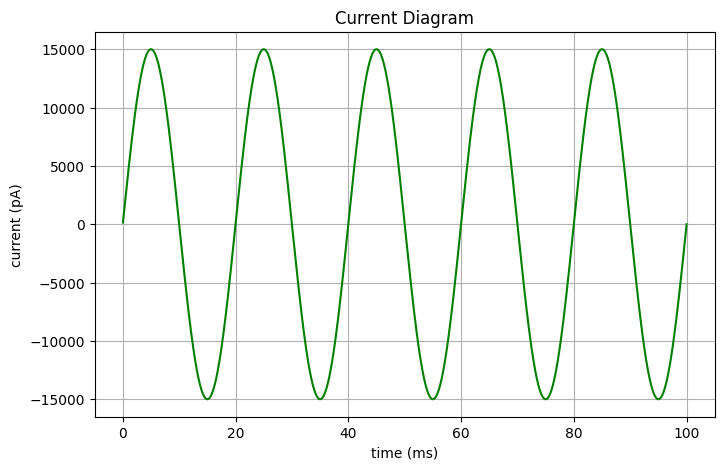

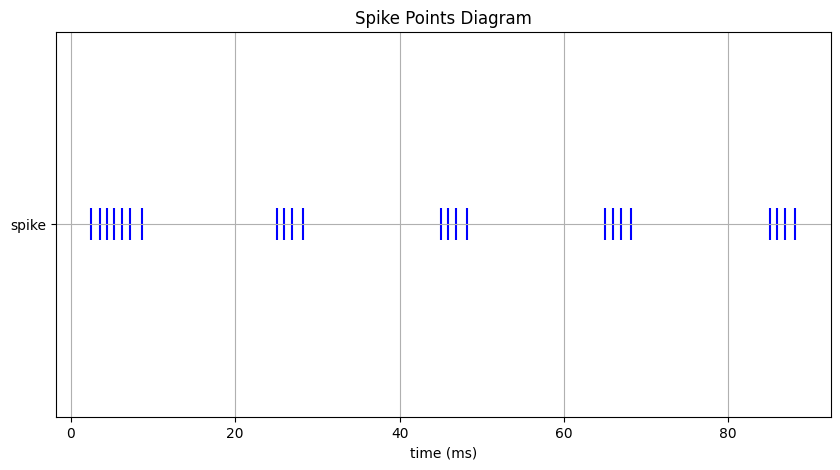

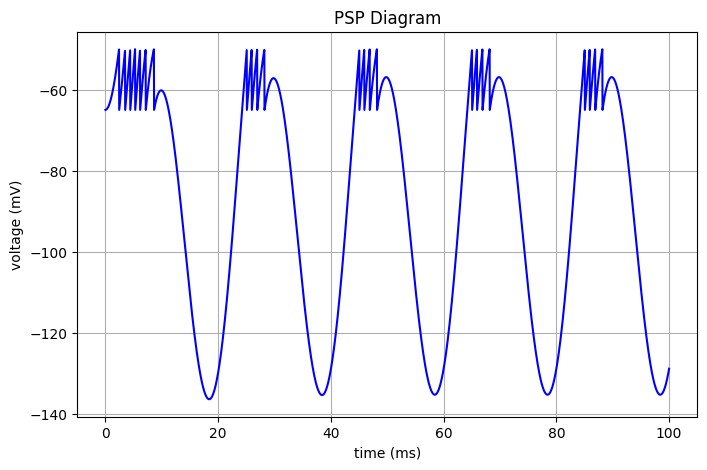

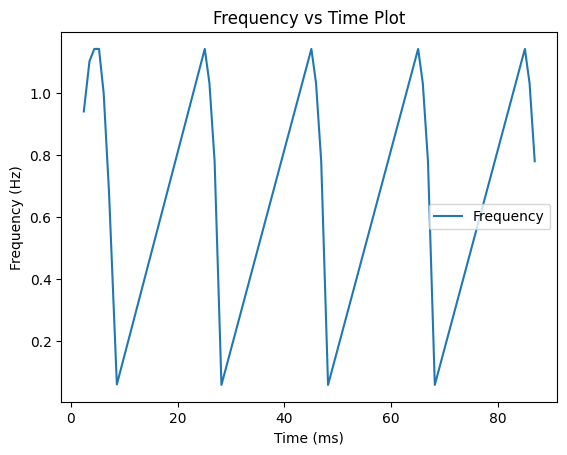

Iteration 7 completed.


In [ ]:
zero_noise_std = 0.0
first_amp = 8000
n_currs = 8
currs , models = [], []
FI = np.zeros([n_currs, 2])
for i in range (n_currs):
    amp =  first_amp + 1000*i
    print('***\n iter {}: current noise std = {} , current amplitude = {} \n'.format(i, zero_noise_std, amp))
    cur = noisy_cur(amplitude=amp, frequency=0.05, noise_std=zero_noise_std)
    model = LIF()
    currs.append(cur)
    models.append(model)
    times, currents, freqs = model_run(cur, model, i)

## D) setting the 5 defferents of parameters

In [ ]:
# Generate a current signal without noise using the `current_df_gen` function
sign_current = current_df_gen()

# Generate a noisy sine wave current signal using the `noisy_cur` function with specified parameters
noisy_sine_current = noisy_cur(amplitude=5000, frequency=0.05, noise_std=0.3)

# Define a list of tuples, with each tuple containing parameter values for an LIF neuron model
params = [(0.01+0.005*i, 8+0.5*i, -65+2*i, -50-i) for i in range(10)]

# Create a list of LIF neuron models using the `LIF` class, with each model corresponding to a set of parameters in `params`
models = [LIF(R, tau, u_rest, u_th) for R, tau, u_rest, u_th in params]

***
 R, tau, u_rest, u_th : (0.01, 8.0, -65, -50)



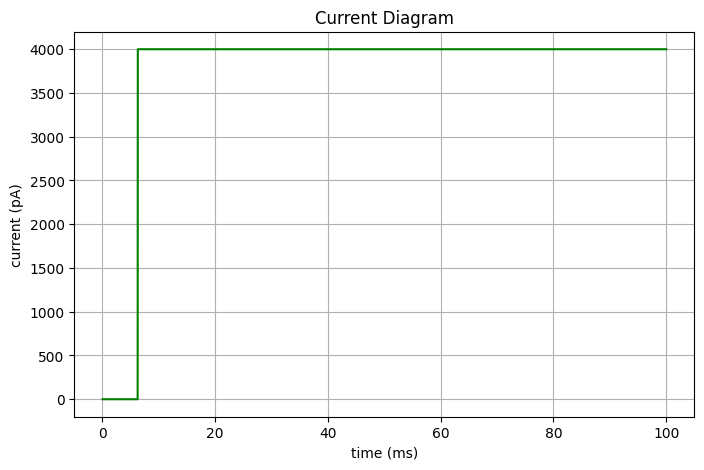

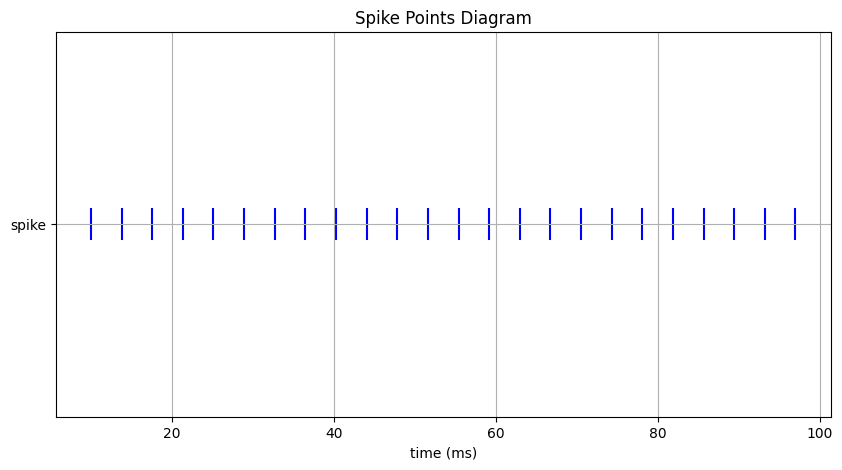

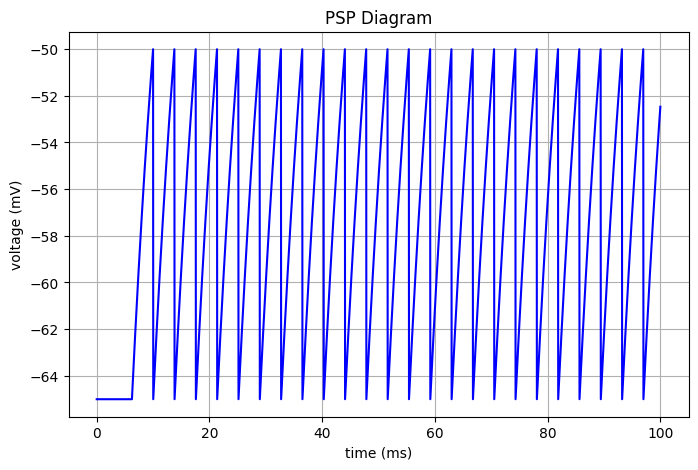

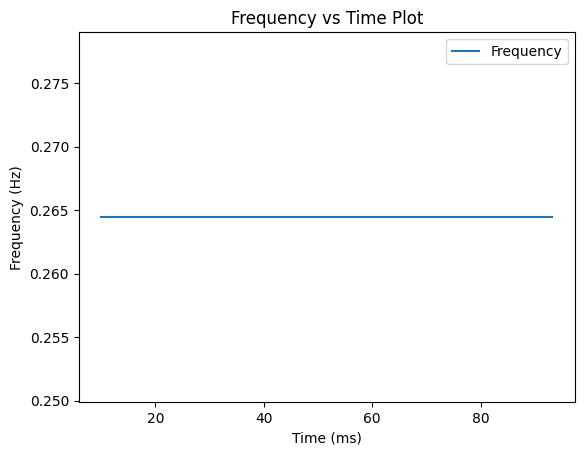

Iteration 0 completed.
***
 R, tau, u_rest, u_th : (0.015, 8.5, -63, -51)



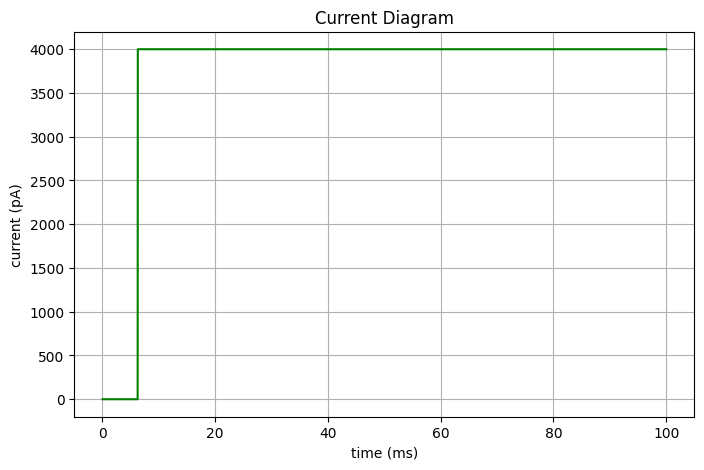

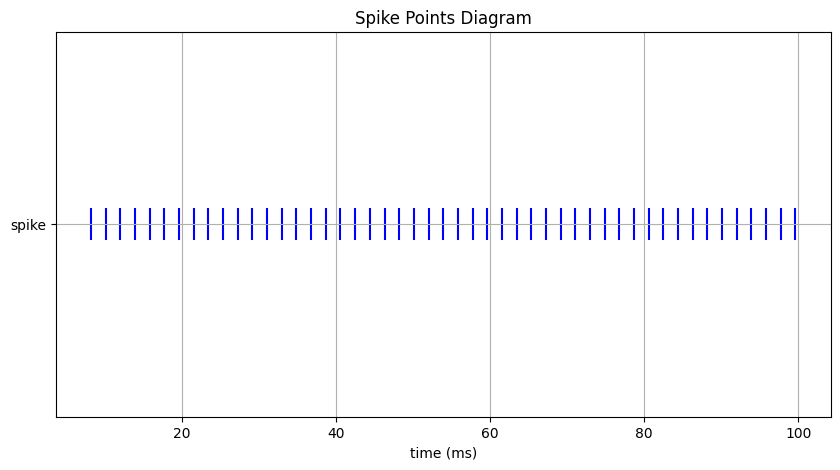

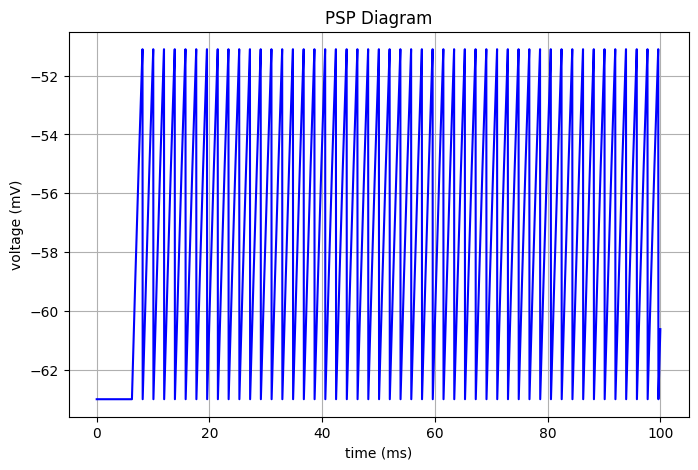

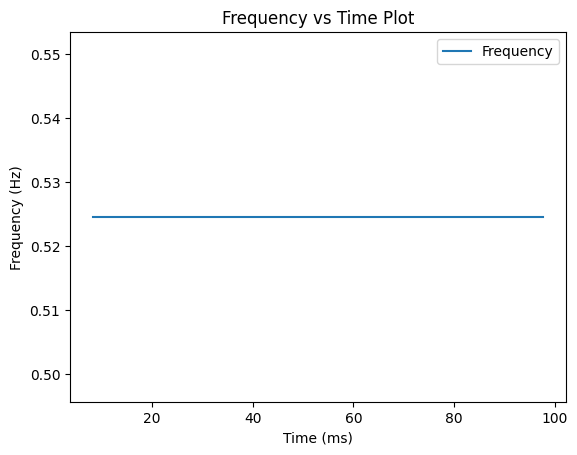

Iteration 1 completed.
***
 R, tau, u_rest, u_th : (0.02, 9.0, -61, -52)



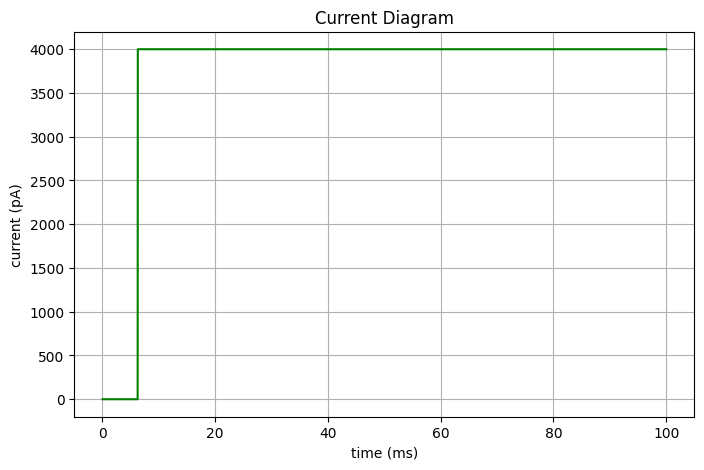

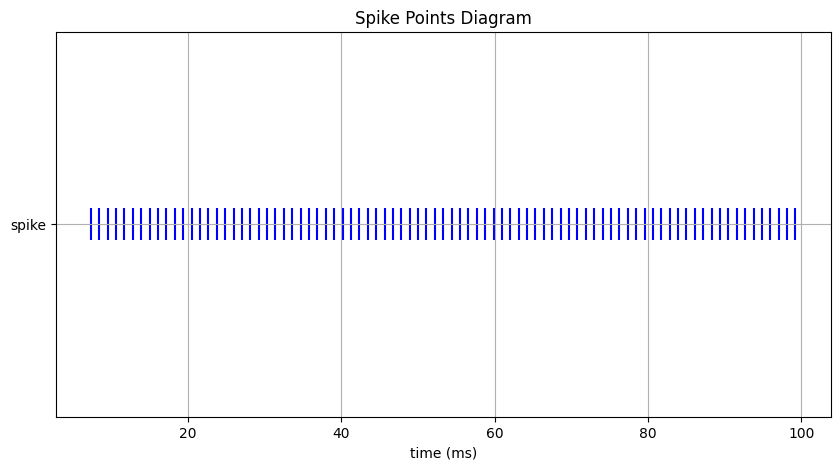

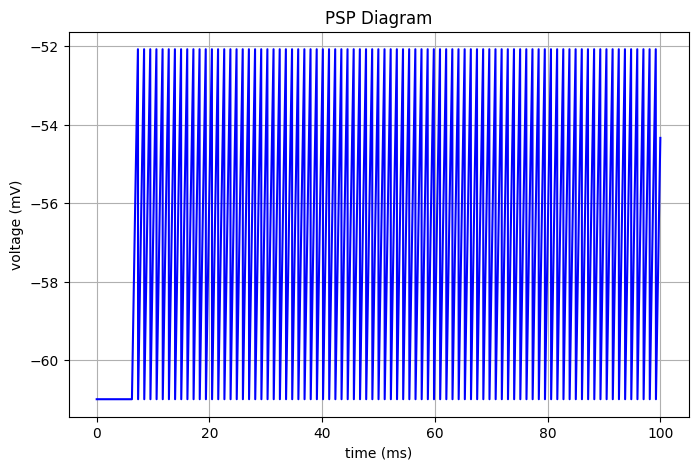

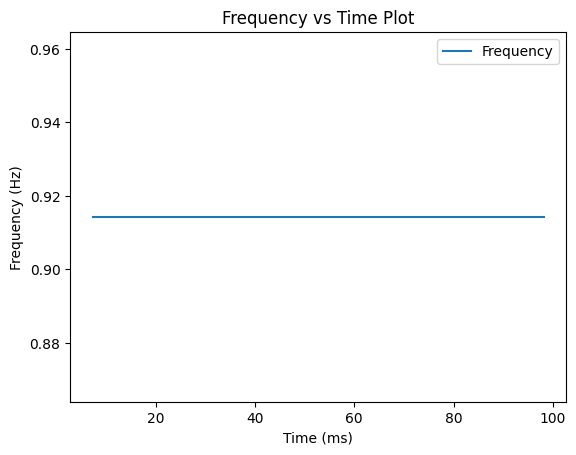

Iteration 2 completed.
***
 R, tau, u_rest, u_th : (0.025, 9.5, -59, -53)



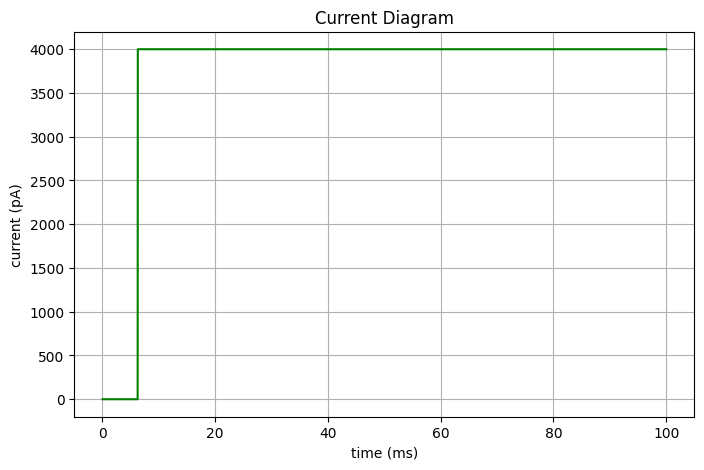

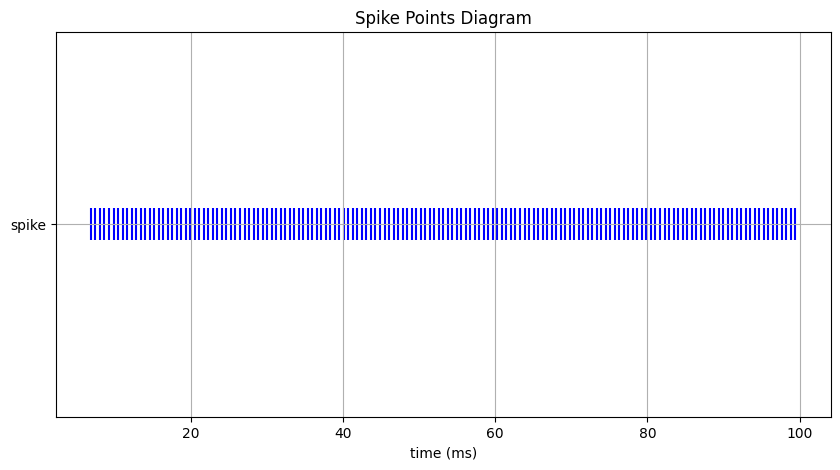

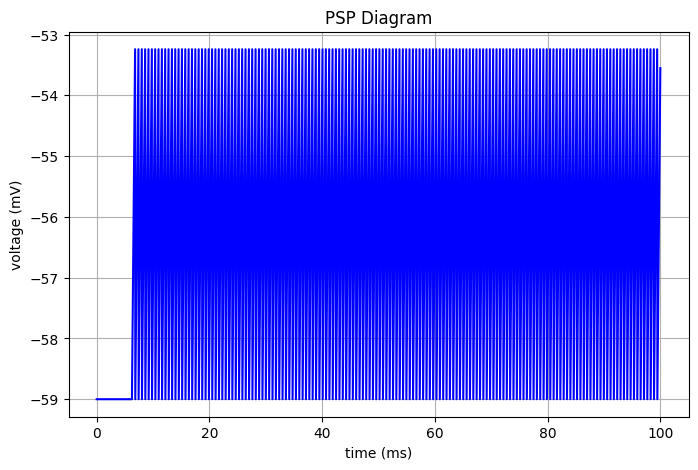

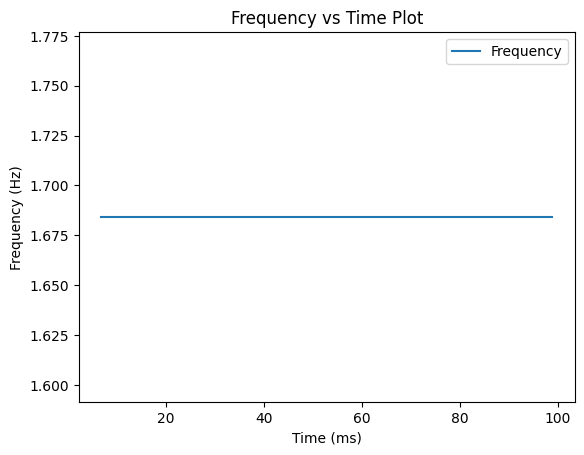

Iteration 3 completed.
***
 R, tau, u_rest, u_th : (0.03, 10.0, -57, -54)



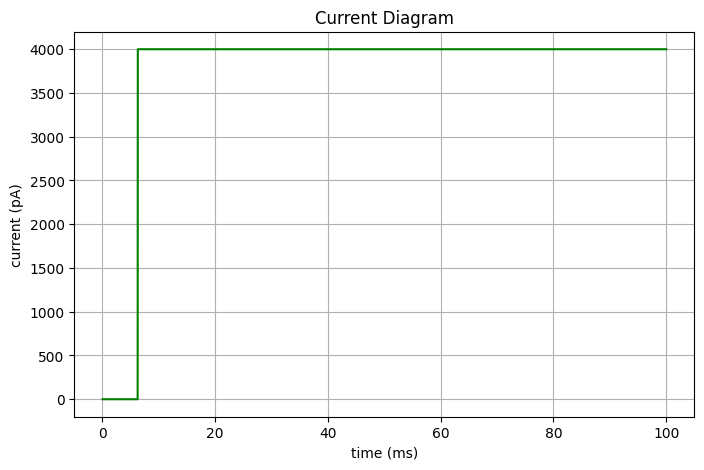

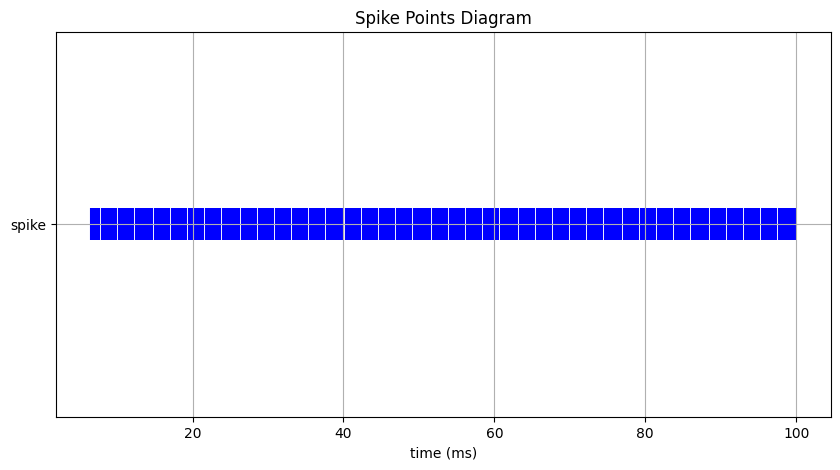

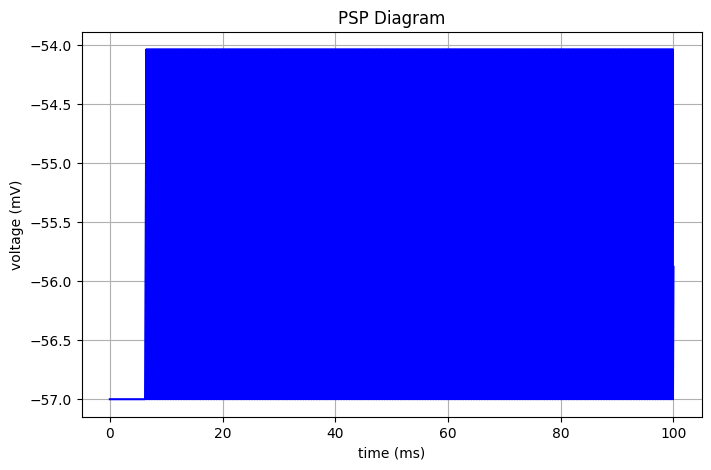

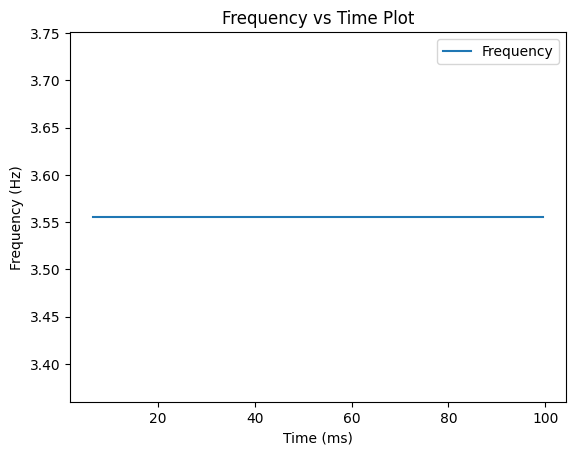

Iteration 4 completed.
***
 R, tau, u_rest, u_th : (0.035, 10.5, -55, -55)



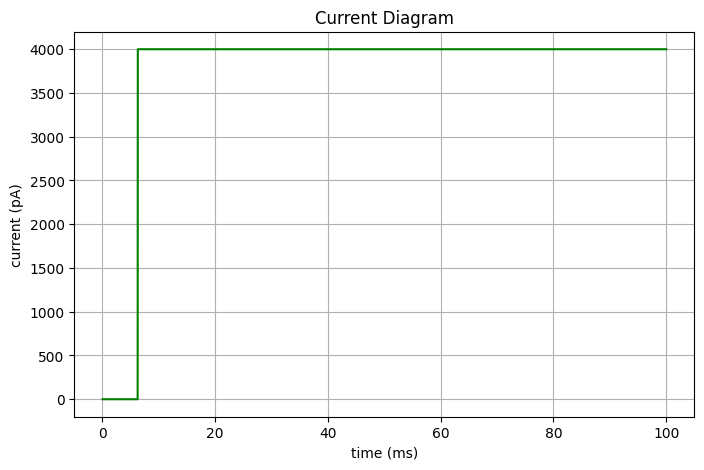

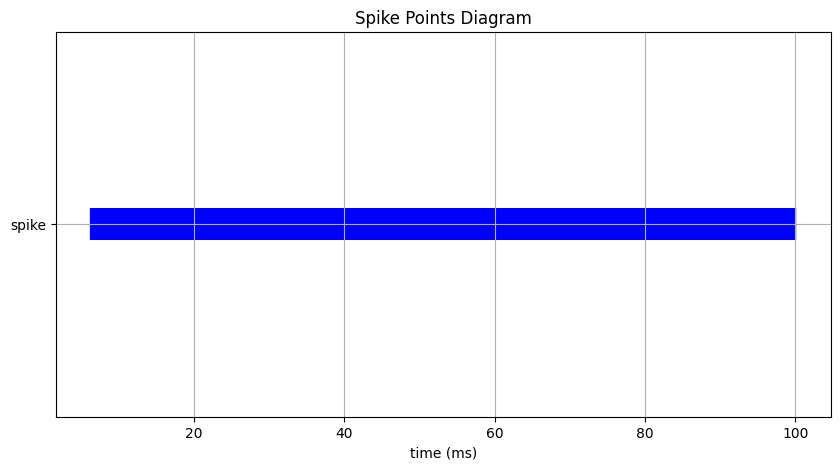

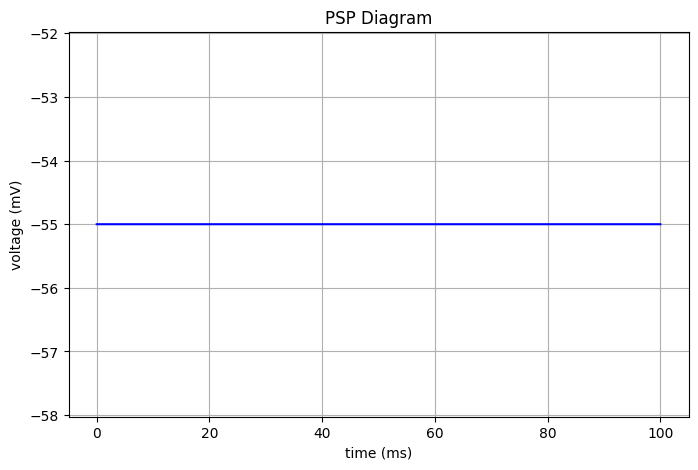

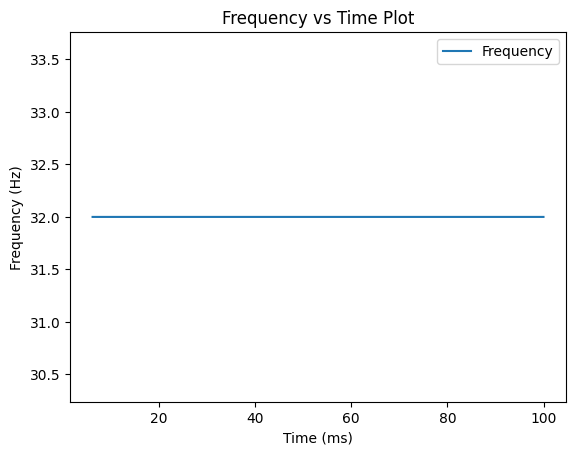

Iteration 5 completed.
***
 R, tau, u_rest, u_th : (0.04, 11.0, -53, -56)



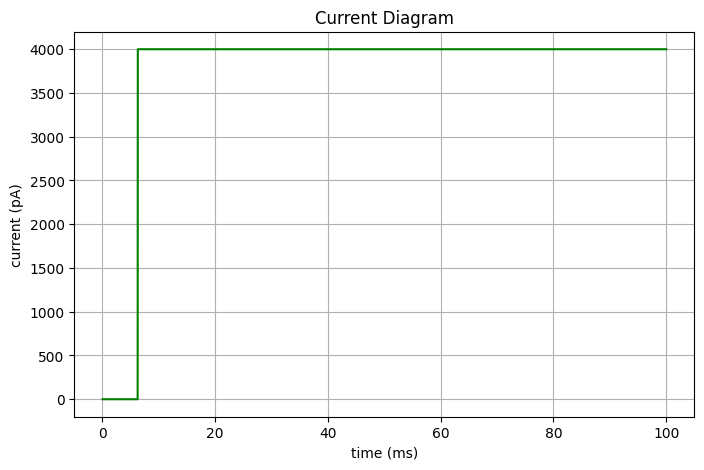

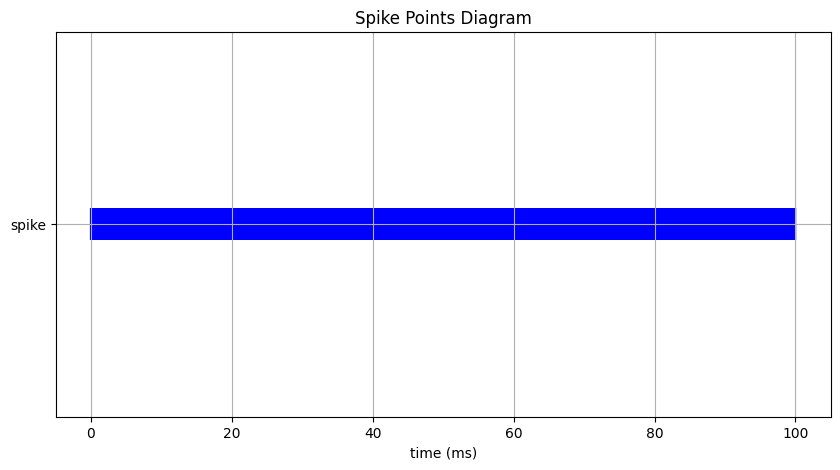

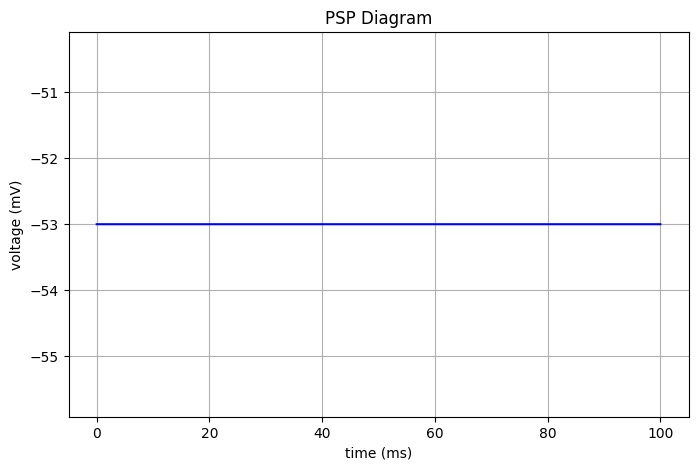

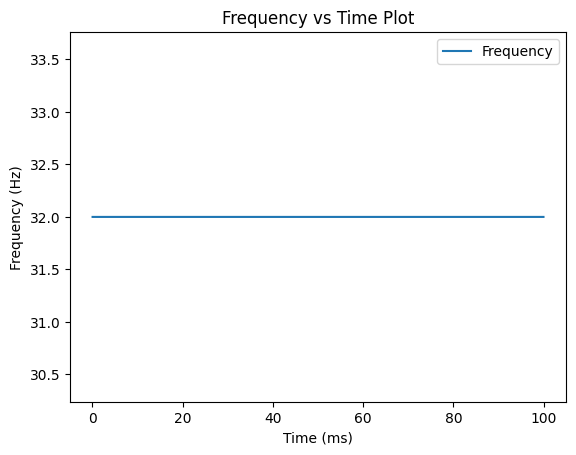

Iteration 6 completed.
***
 R, tau, u_rest, u_th : (0.045000000000000005, 11.5, -51, -57)



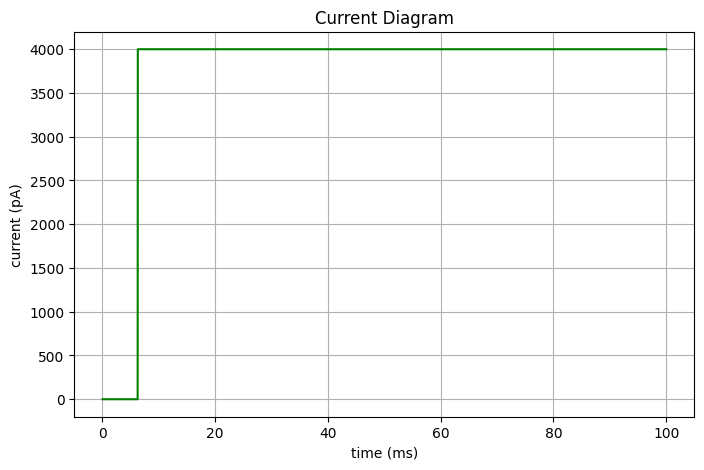

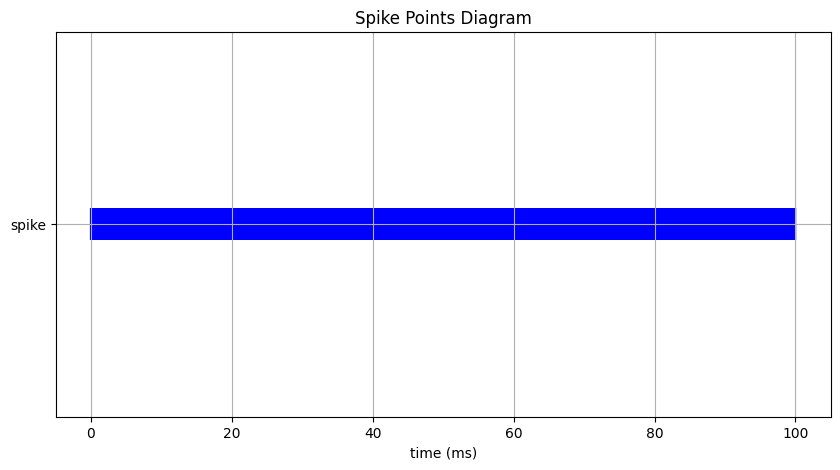

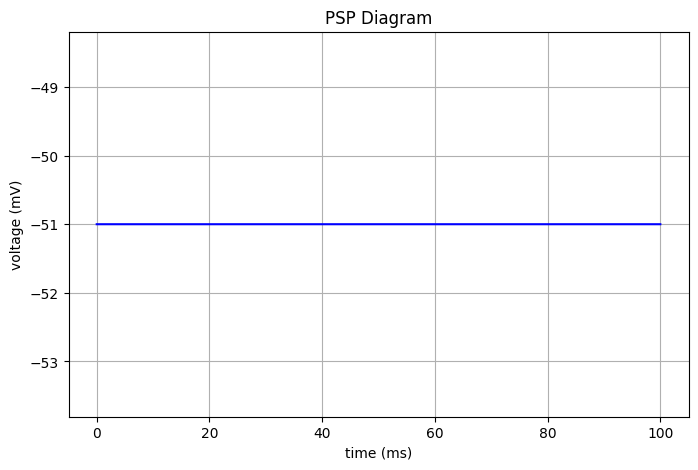

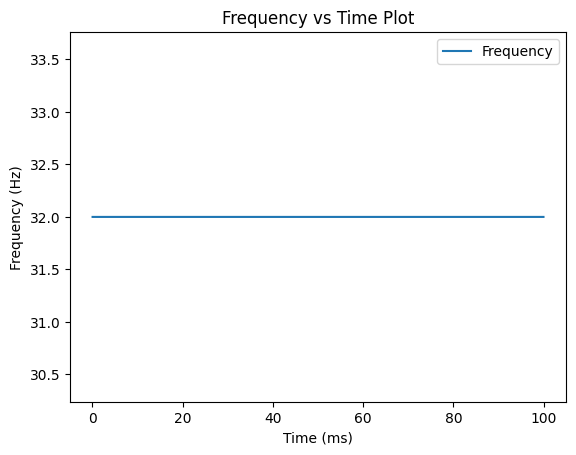

Iteration 7 completed.
***
 R, tau, u_rest, u_th : (0.05, 12.0, -49, -58)



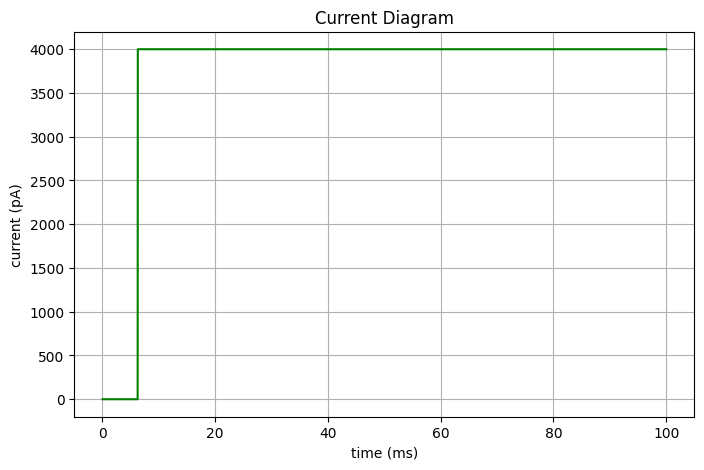

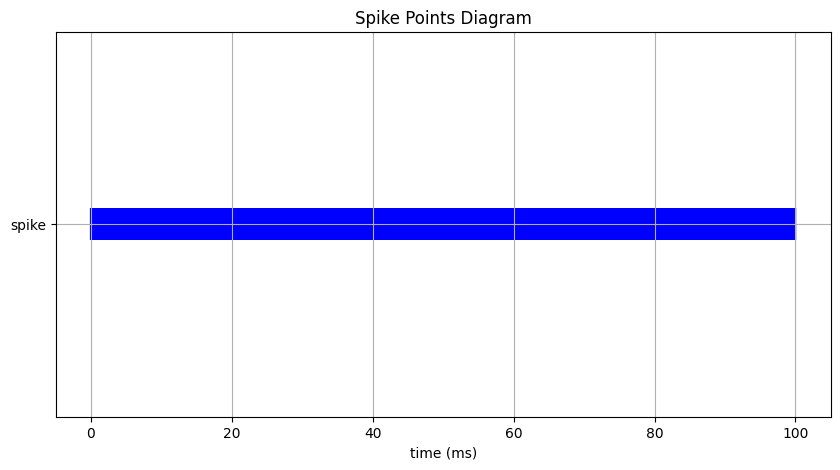

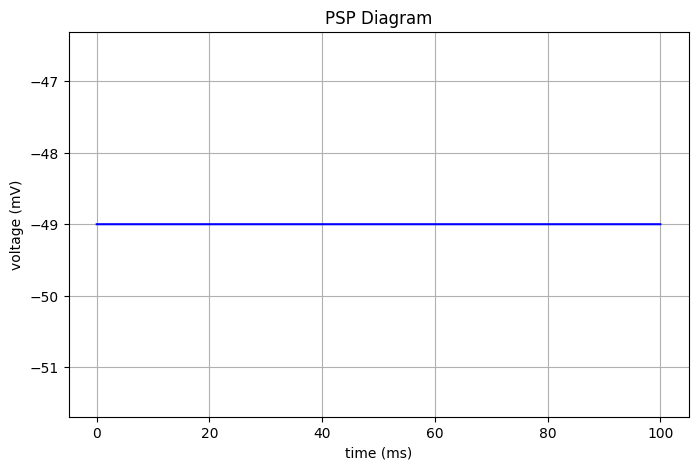

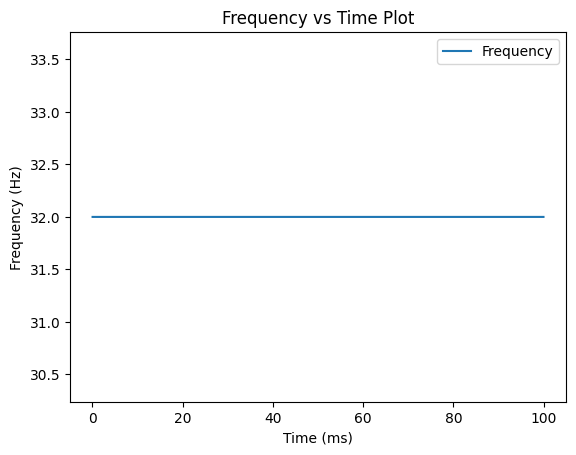

Iteration 8 completed.
***
 R, tau, u_rest, u_th : (0.055, 12.5, -47, -59)



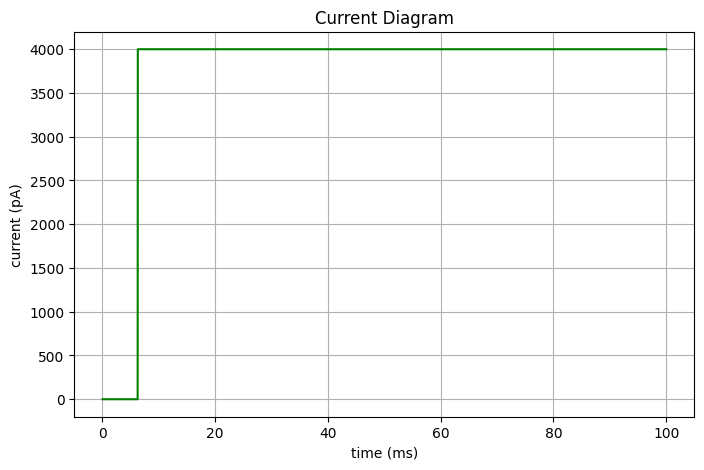

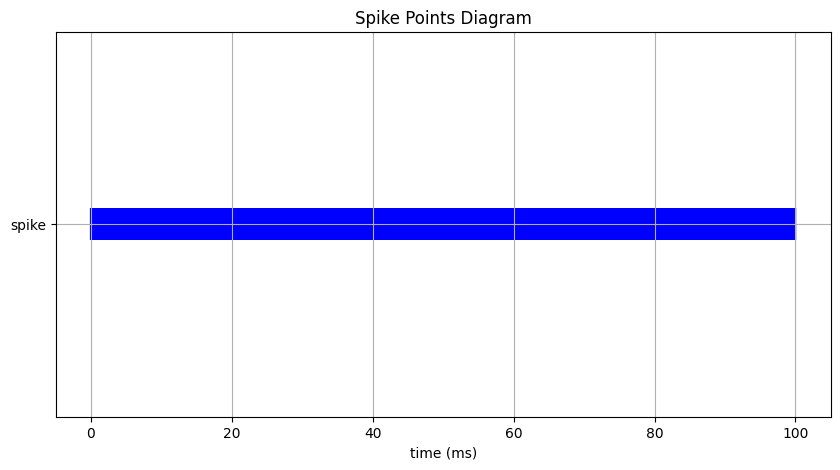

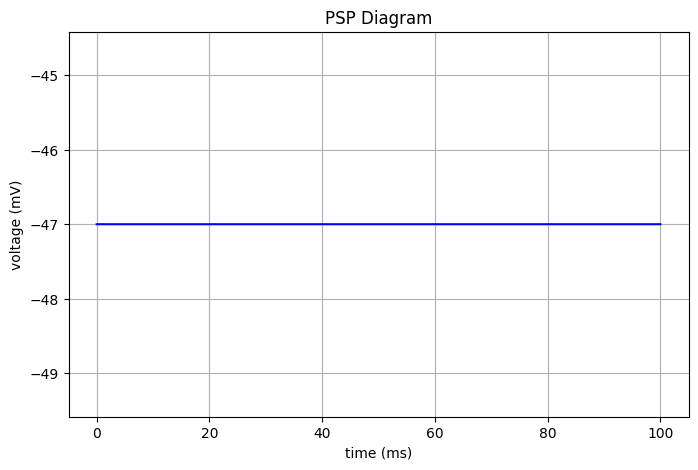

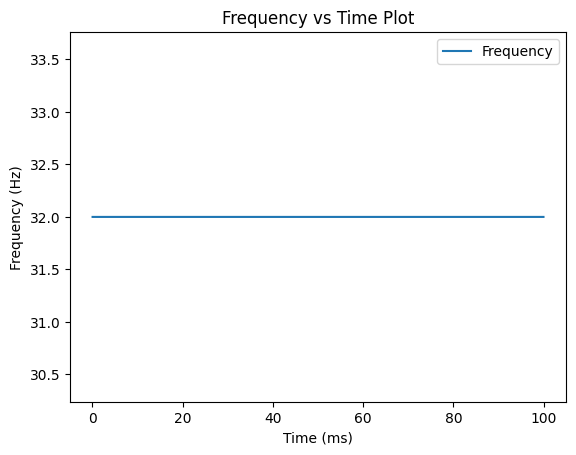

Iteration 9 completed.


In [ ]:
# Iterate over the list of LIF neuron models and their corresponding parameter sets using `enumerate` and `zip`
for i, (model, paramset) in enumerate(list(zip(models, params))):

    # Print the parameter set for the current model
    print('***\n R, tau, u_rest, u_th : {}\n'.format(paramset))

    # Run the model with the `model_run` function using the `sign_current` signal and the current model
    # The `i` parameter is used as a seed for the random number generator in `model_run`
    times, currents, freqs = model_run(sign_current, model, i)

***
 R, tau, u_rest, u_th : (0.01, 8.0, -65, -50)



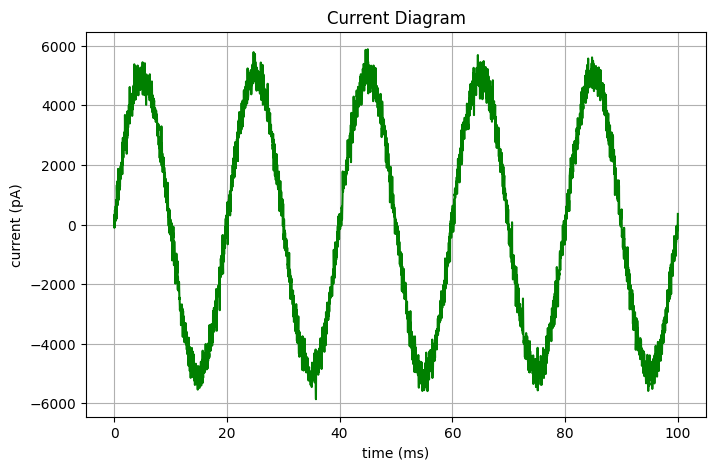

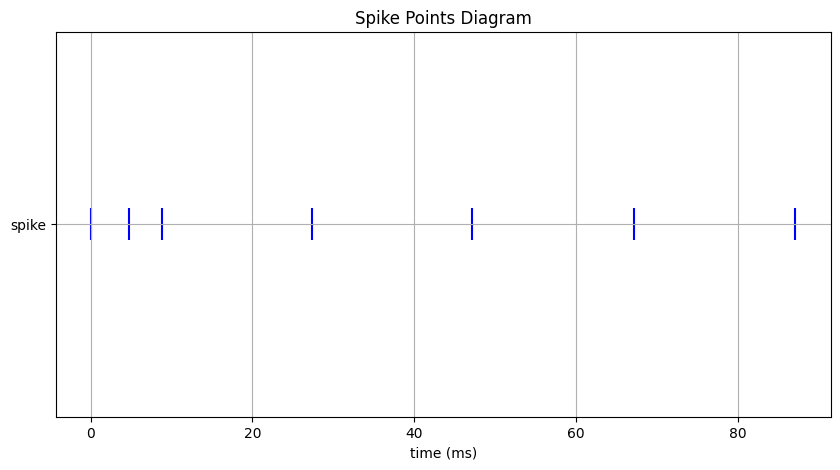

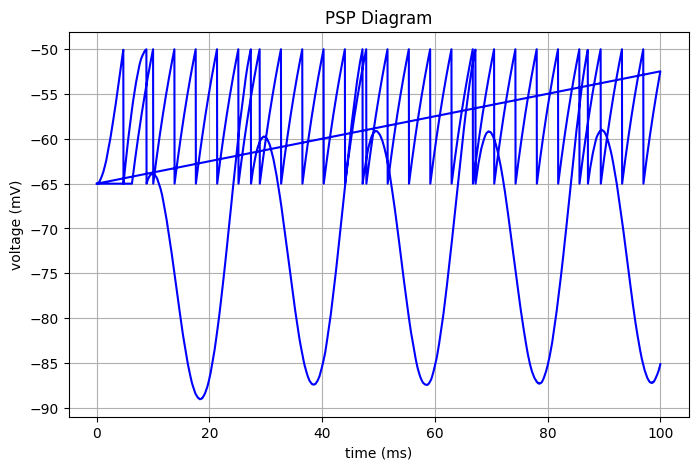

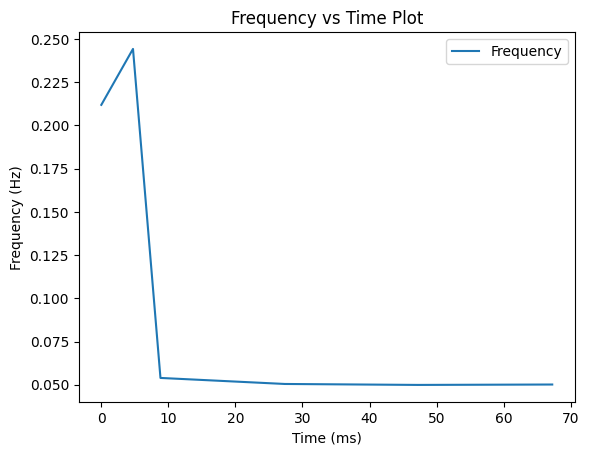

Iteration 0 completed.
***
 R, tau, u_rest, u_th : (0.015, 8.5, -63, -51)



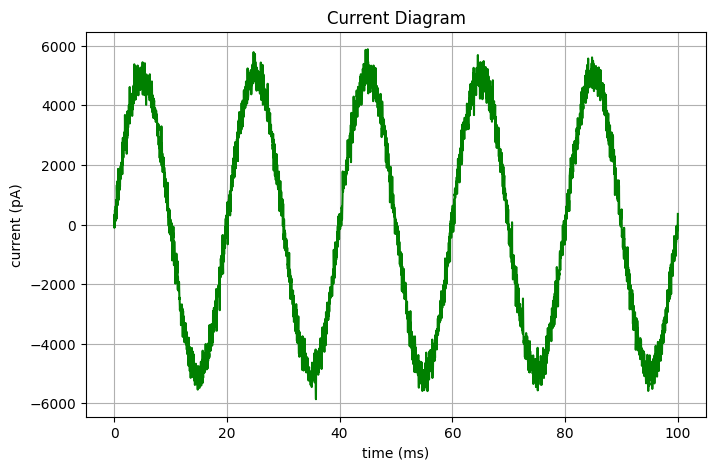

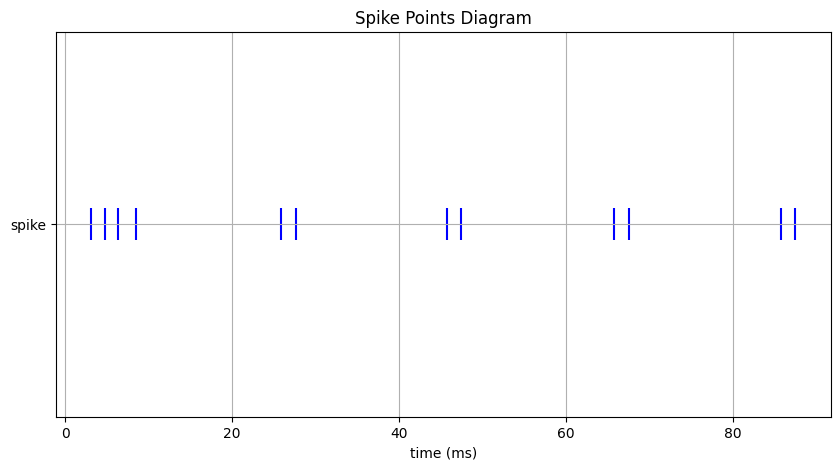

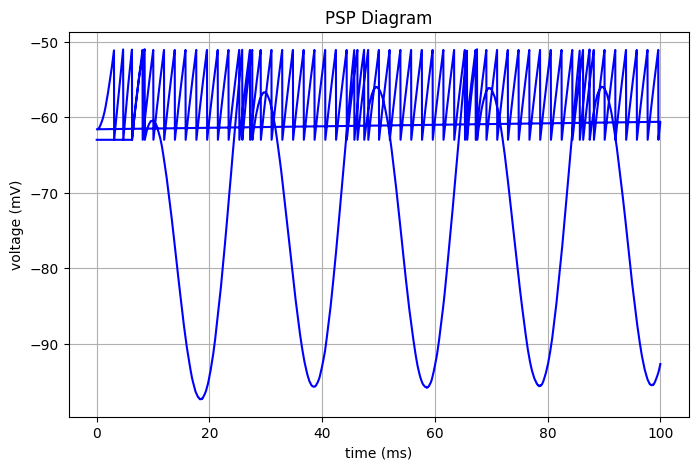

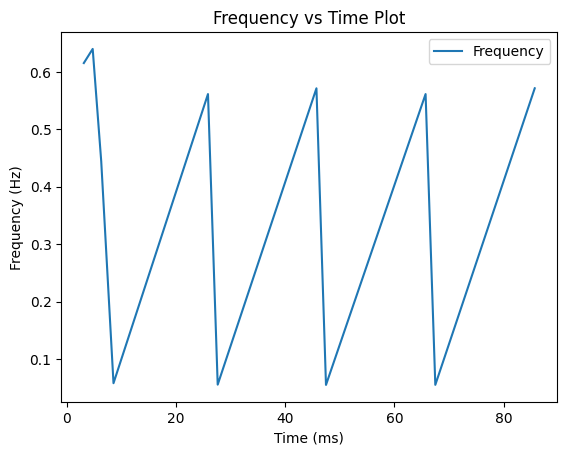

Iteration 1 completed.
***
 R, tau, u_rest, u_th : (0.02, 9.0, -61, -52)



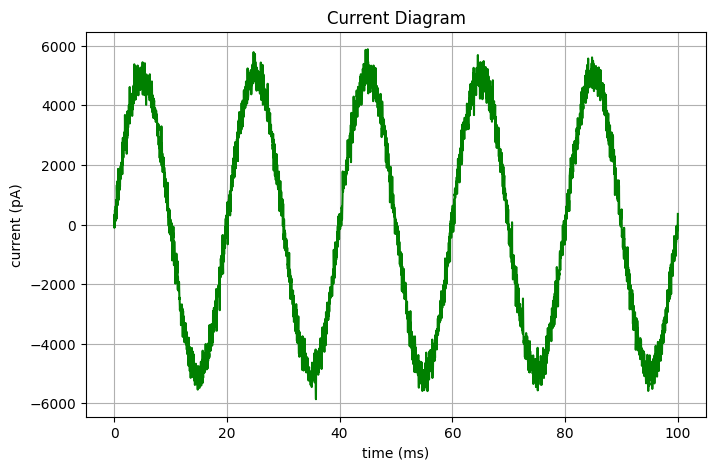

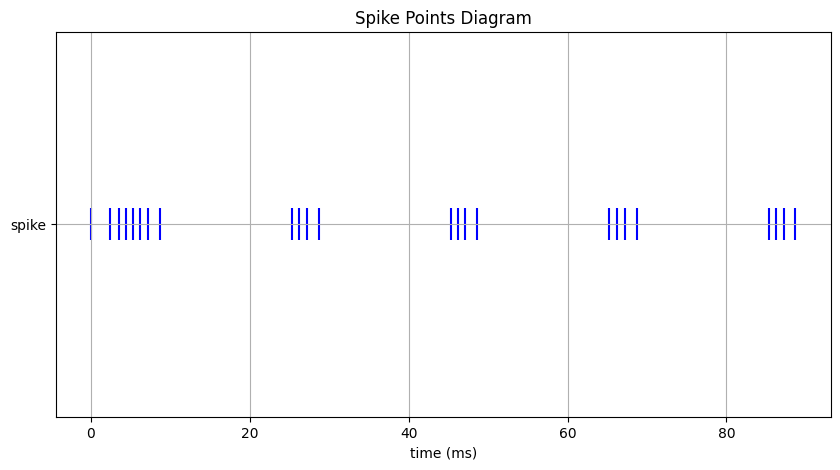

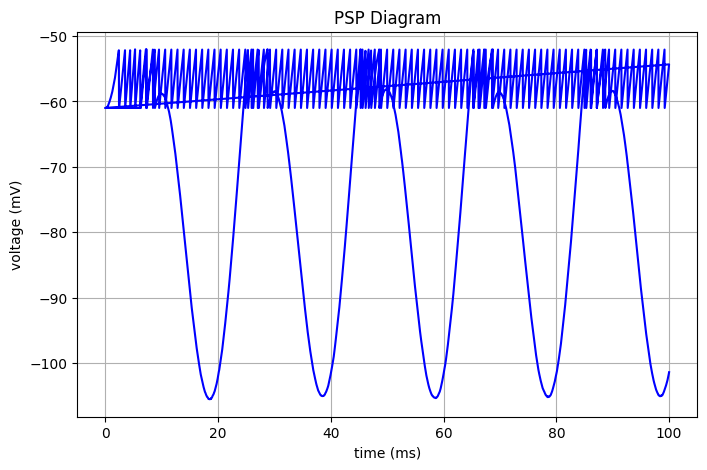

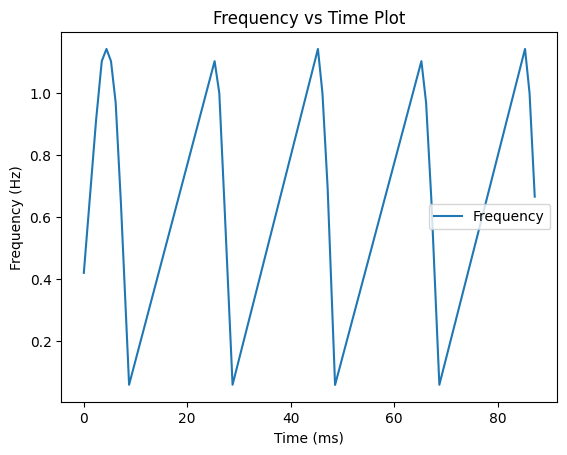

Iteration 2 completed.
***
 R, tau, u_rest, u_th : (0.025, 9.5, -59, -53)



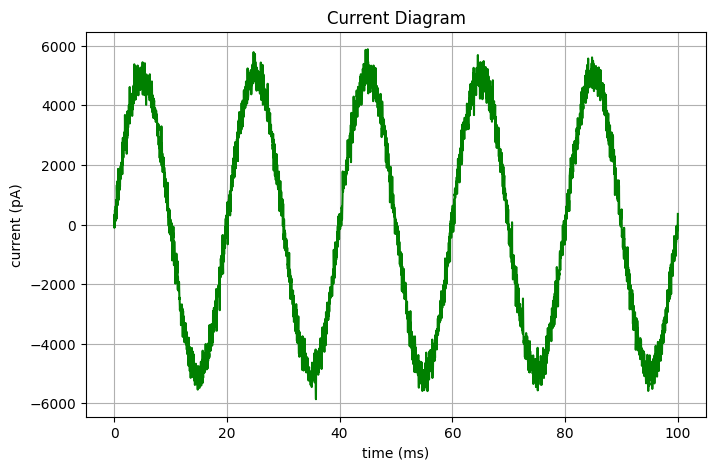

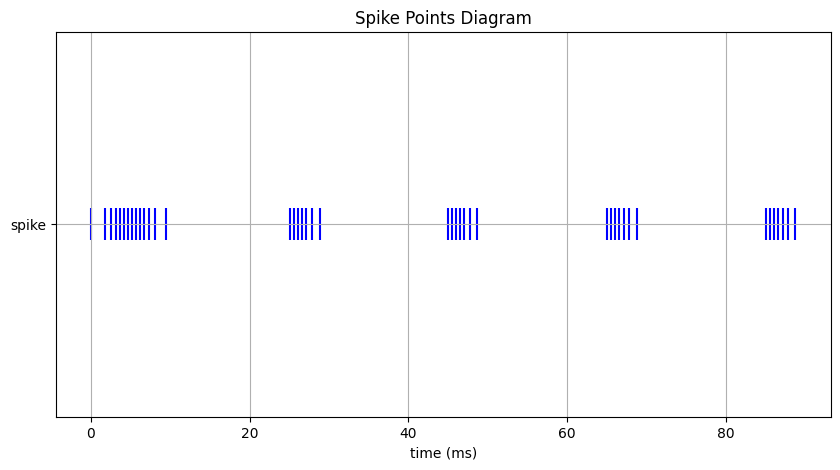

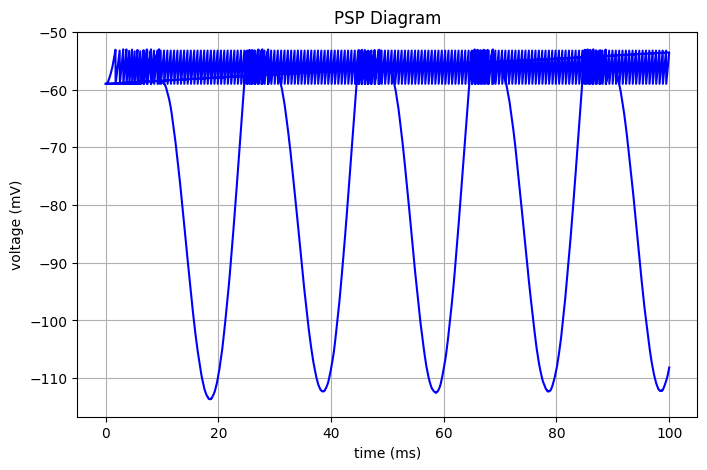

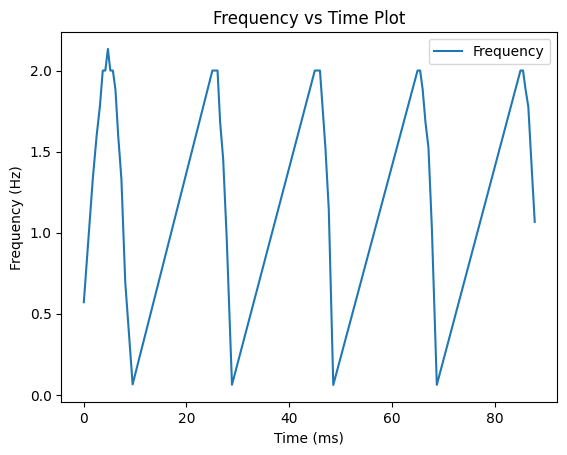

Iteration 3 completed.
***
 R, tau, u_rest, u_th : (0.03, 10.0, -57, -54)



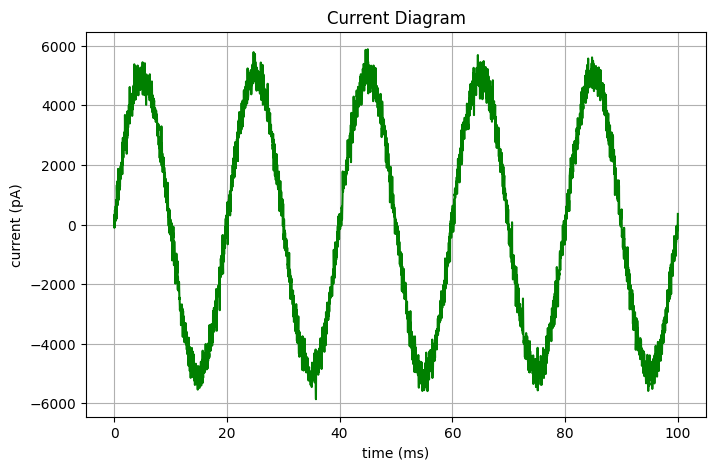

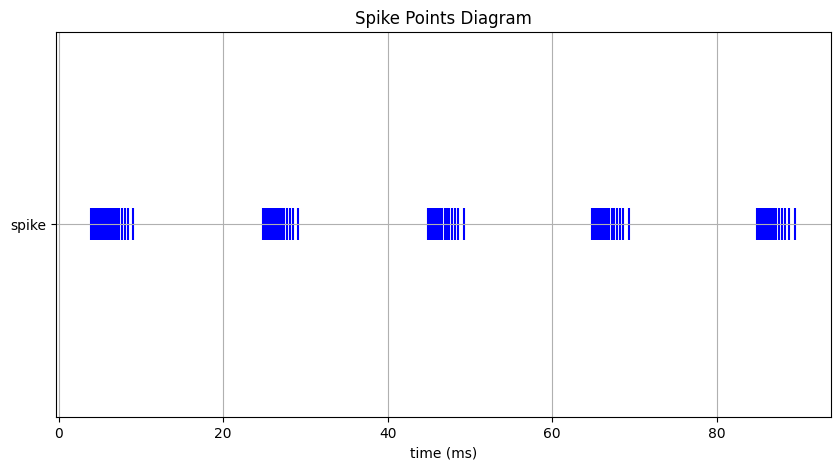

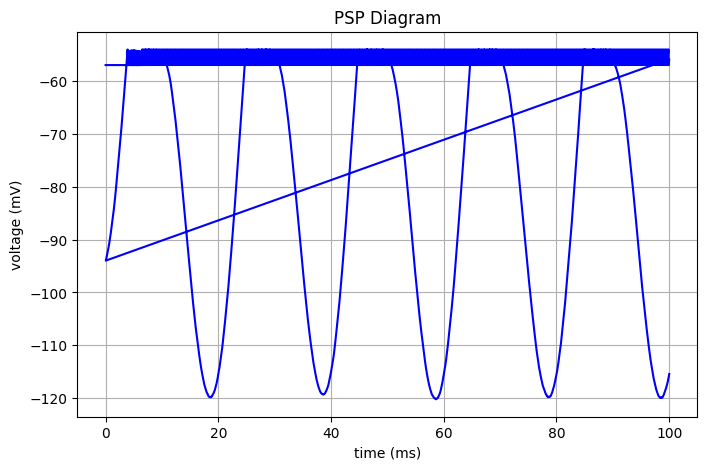

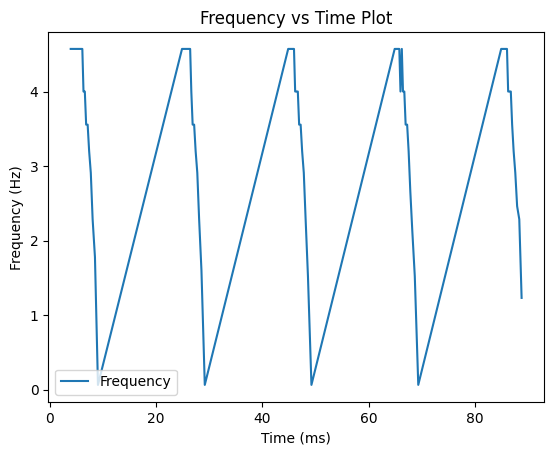

Iteration 4 completed.
***
 R, tau, u_rest, u_th : (0.035, 10.5, -55, -55)



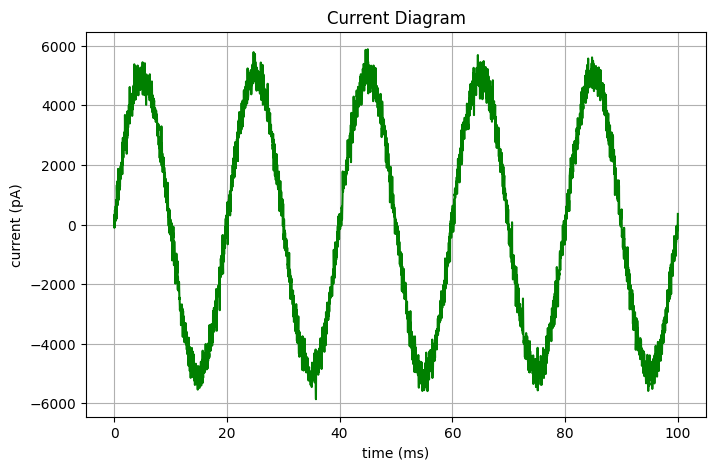

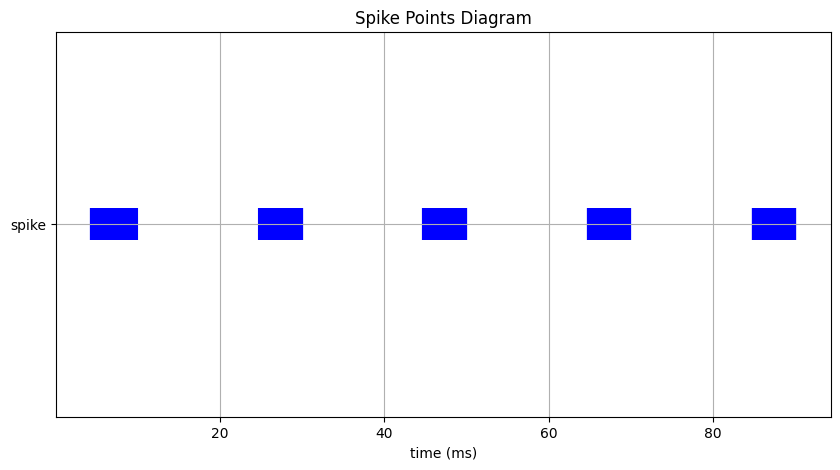

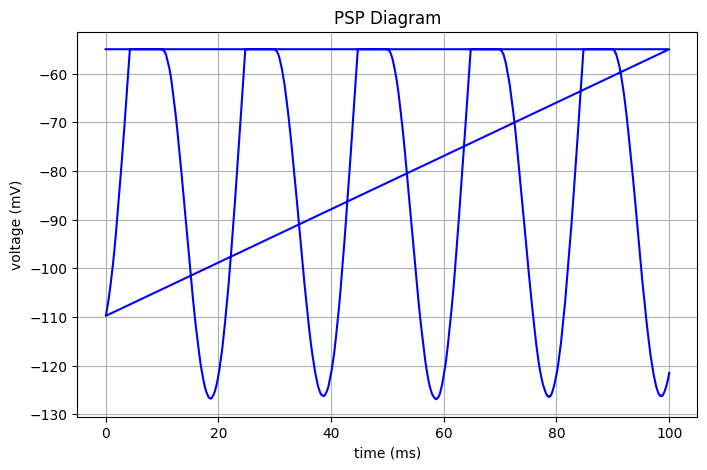

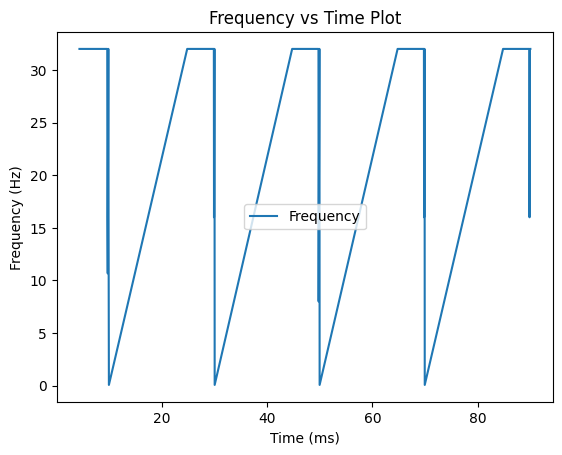

Iteration 5 completed.
***
 R, tau, u_rest, u_th : (0.04, 11.0, -53, -56)



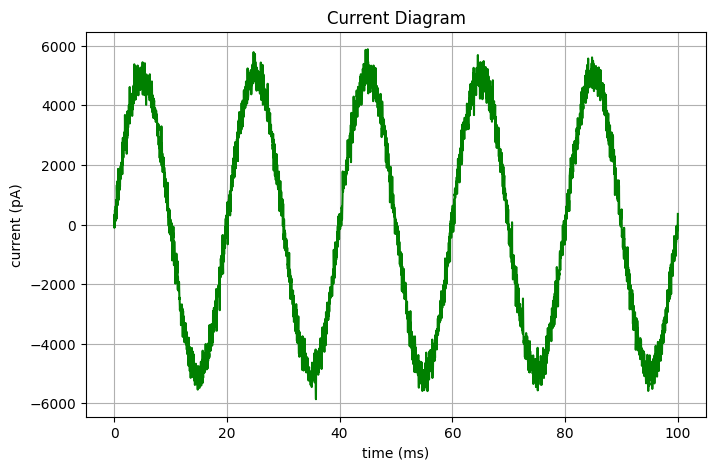

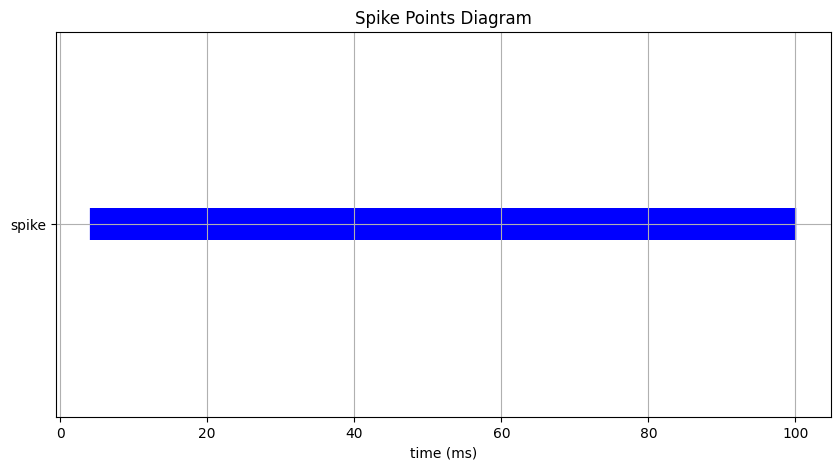

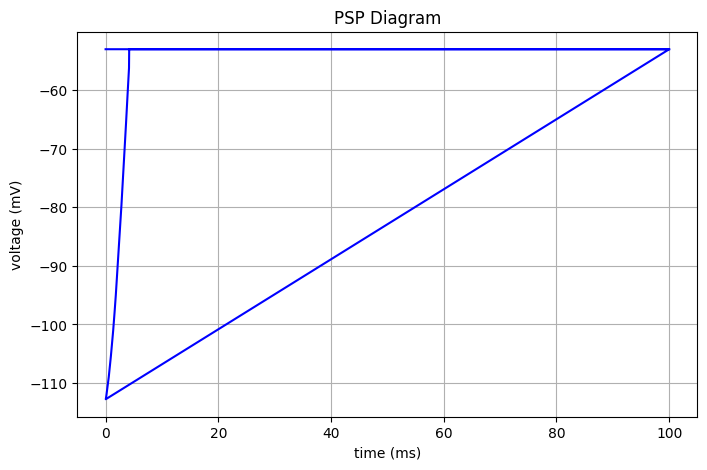

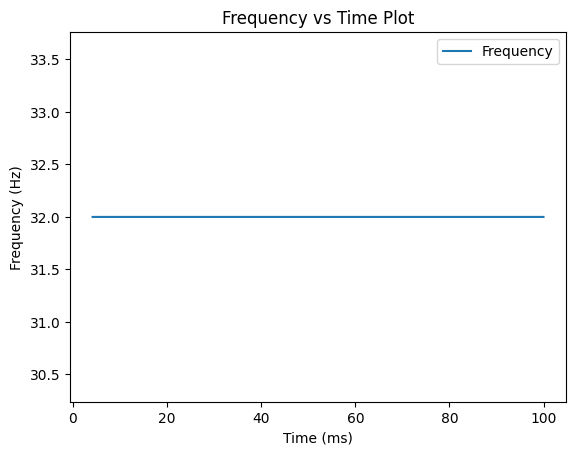

Iteration 6 completed.
***
 R, tau, u_rest, u_th : (0.045000000000000005, 11.5, -51, -57)



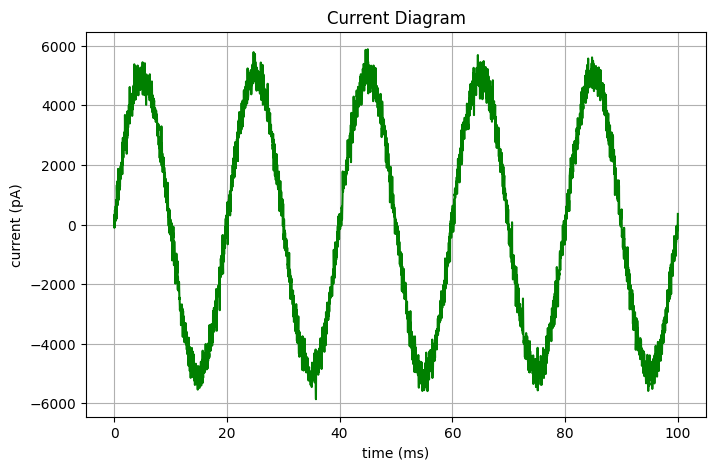

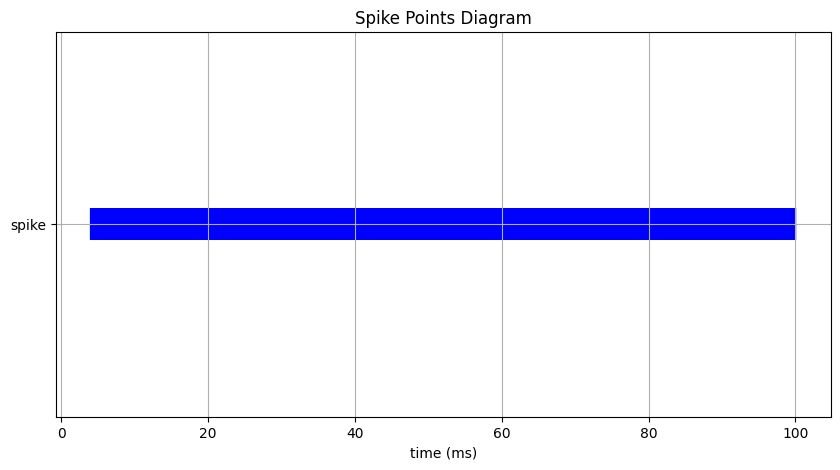

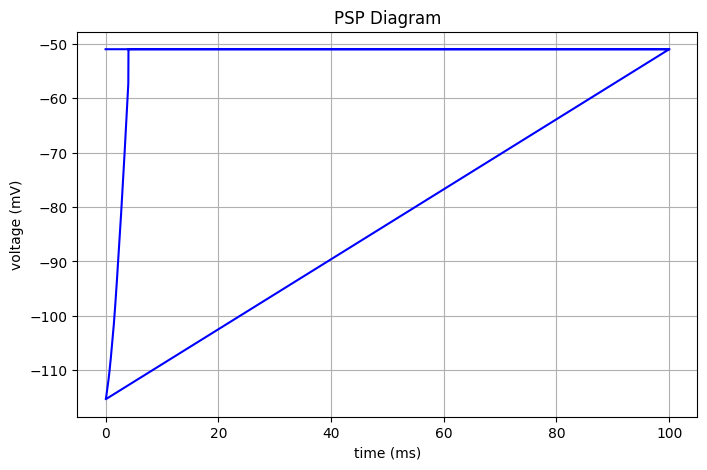

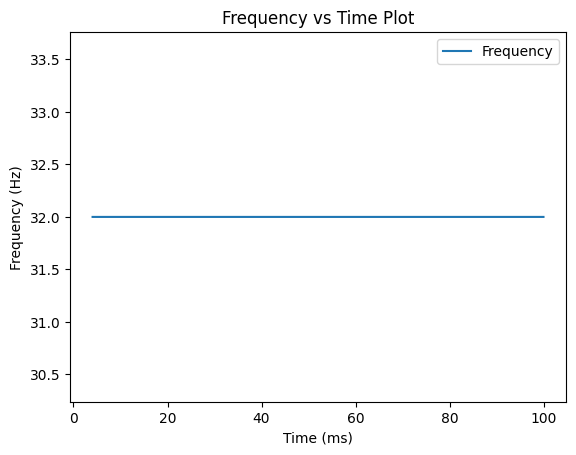

Iteration 7 completed.
***
 R, tau, u_rest, u_th : (0.05, 12.0, -49, -58)



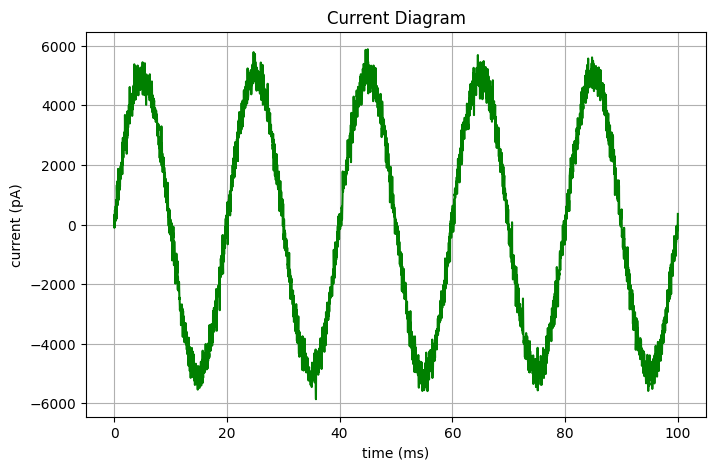

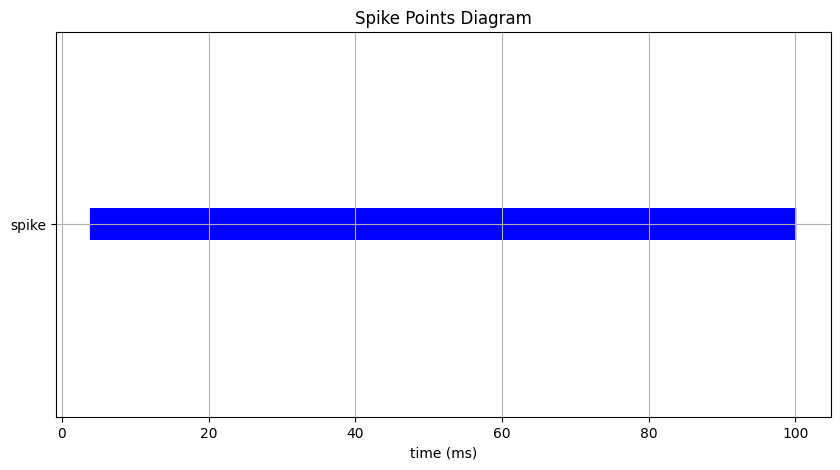

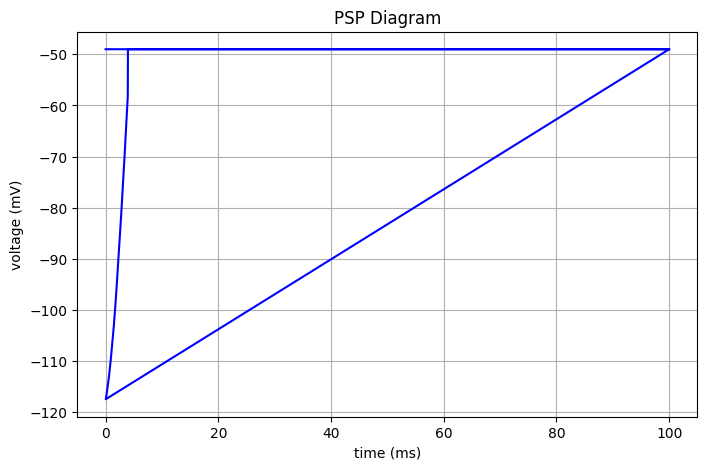

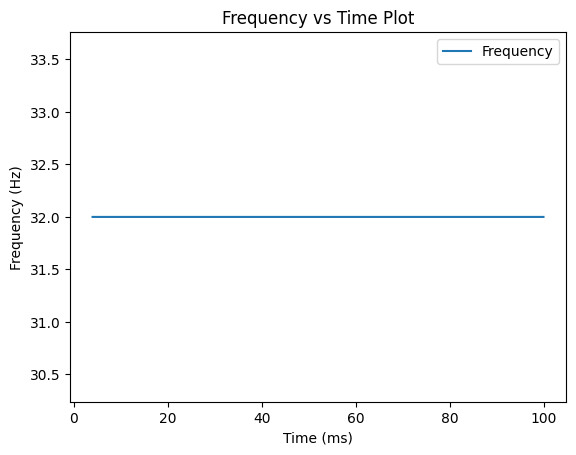

Iteration 8 completed.
***
 R, tau, u_rest, u_th : (0.055, 12.5, -47, -59)



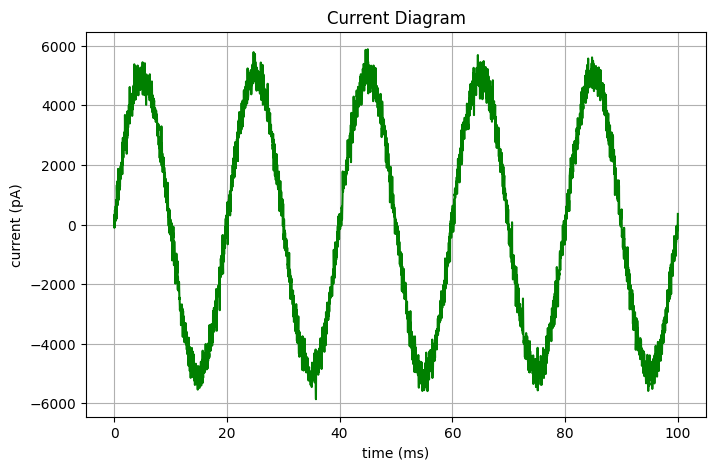

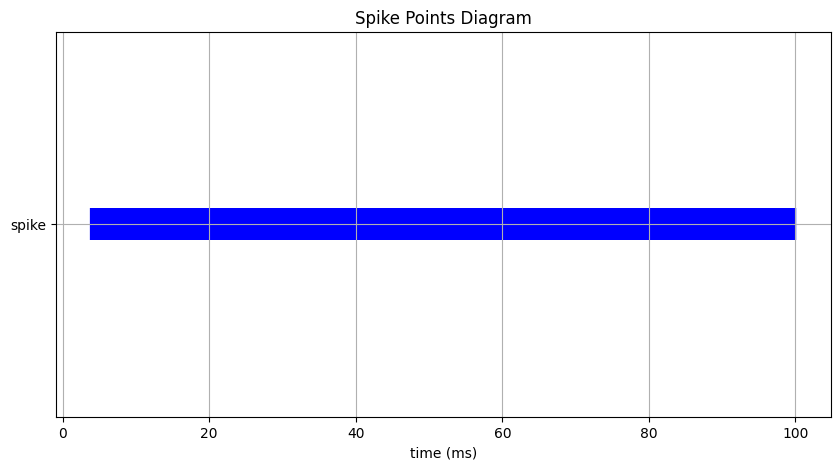

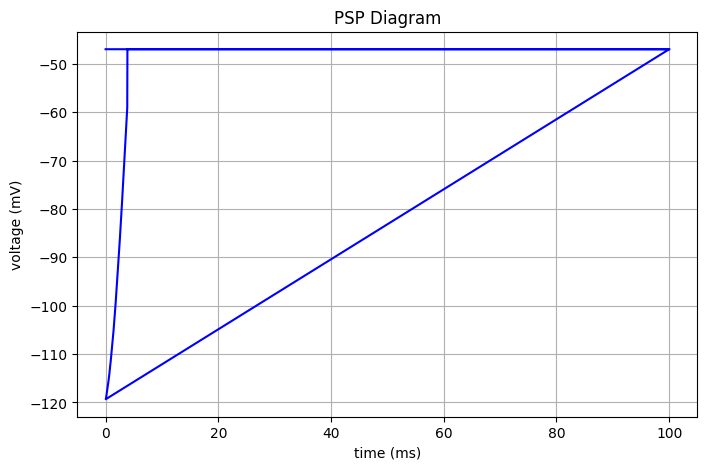

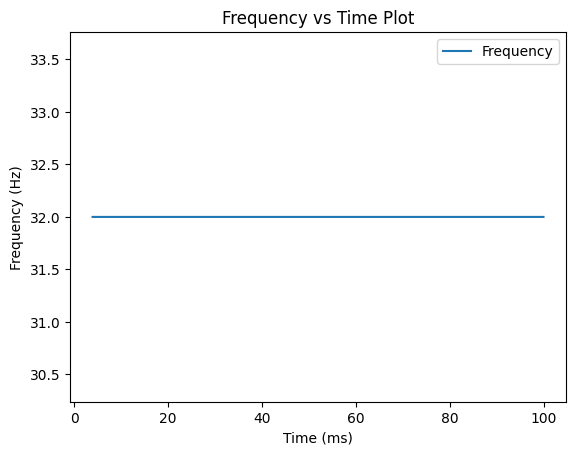

Iteration 9 completed.


In [ ]:
# Iterate over the list of LIF neuron models and their corresponding parameter sets using `enumerate` and `zip`
for i, (model, paramset) in enumerate(list(zip(models, params))):

    # Print the parameter set for the current model
    print('***\n R, tau, u_rest, u_th : {}\n'.format(paramset))

    # Run the model with the `model_run` function using the `noisy_sine_current` signal and the current model
    # The `i` parameter is used as a seed for the random number generator in `model_run`
    times, currents, freqs = model_run(noisy_sine_current, model, i)

### The effect of having u_th and u_rest values that are close together can be observed in the form of a high spike frequency in the peaks of the sine current.